# Exploratory Data Analysis of Last.fm's Mood Tags

The Last.fm Tags dataset is a complementary dataset included as part of the Million Song Dataset. More information can be found [here](https://labrosa.ee.columbia.edu/millionsong/lastfm).

The dataset is available in several different forms including individual json files for each track as well as an sqlite db. Iterating over the json files is cumbersome, so we make use of the sqlite db here.

The goal of this workbook is to explore the tags available in the Last.fm dataset with a special focus on the moods targeted in our project.

In [21]:
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
import pandas as pd
import json
import os

%pprint
%matplotlib inline

Pretty printing has been turned ON


# Getting Started

### Connecting to the DB

In [22]:
from label_lyrics import LASTFM_TAGS_DB
import sqlite3

dbpath = os.path.abspath(LASTFM_TAGS_DB)
print(dbpath)
conn = sqlite3.connect(dbpath)
conn

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/data/lastfm_tags.db


### Example Last.fm Tags Queries

These examples are taken from the very helpful [MSD provided example code](https://labrosa.ee.columbia.edu/millionsong/sites/default/files/lastfm/demo_tags_db.py) demonstrating how to work with the last.fm sqlite db.

In [23]:
from label_lyrics import sanitize

In [24]:
print('************** DEMO 4 **************')
tag = 'Acid Smurfs'
print('We get all tracks for the tag: {0}'.format(tag))
sql = "SELECT tids.tid FROM tags, tids, tid_tag WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tags.tag='{0}'".format(sanitize(tag))
res = conn.execute(sql)
data = res.fetchall()

pprint(data)

************** DEMO 4 **************
We get all tracks for the tag: Acid Smurfs
[('TRDATLJ128F92FC75F',),
 ('TRVTZIF128F42725C1',),
 ('TREPQOO128F9328886',),
 ('TROXKKP128F427886F',)]


In [25]:
print('************** DEMO 5 **************')
print("We get all tags and the number of tracks they're applied to")
sql = "SELECT tags.tag, COUNT(tid_tag.tid) FROM tid_tag, tags WHERE tid_tag.tag=tags.ROWID GROUP BY tags.tag"

### WARNING - this one takes a minute... uncomment these lines to execute
#res = conn.execute(sql)
#data = res.fetchall()
#data = sorted(data, key=lambda x: x[1], reverse=True)
#print('after sorting...')
#for k in range(10):
#    print(data[k])
#print('...')

************** DEMO 5 **************
We get all tags and the number of tracks they're applied to


### Last.fm DB Schema Exploration

In order to use the provided db effectively, we need to know its schema. Here we use sql commands to expose its table structure (credit: https://www.tomordonez.com/get-schema-sqlite-python.html).

It turns out that the schema is incredibly simple.


In [26]:
cur = conn.cursor()

tables = list()
for row in cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall():
    tables.append(row[0])

print('Tables: {0}\n'.format(tables))

for table in tables:
    
    cols = list()
    for row in cur.execute("pragma table_info('{0}')".format(table)).fetchall():
        cols.append(row[1])

    row_count = cur.execute("SELECT Count(*) FROM {0}".format(table)).fetchall()[0][0]
        
    print('Table "{0}"'.format(table))
    print('\tcolumns: {0}'.format(cols))
    print('\trows: {0}'.format(row_count))
    
    #print(cur.execute("SELECT * FROM {0} LIMIT 5".format(table)).fetchall())
    
cur.close()

Tables: ['tags', 'tids', 'tid_tag']

Table "tags"
	columns: ['tag']
	rows: 522366
Table "tids"
	columns: ['tid']
	rows: 505216
Table "tid_tag"
	columns: ['tid', 'tag', 'val']
	rows: 8598630


And here is a quick peek at the beginning five rows of each table.

In [27]:
for table in tables:
    
    df = pd.read_sql_query("SELECT * FROM {0} LIMIT 5".format(table), conn)
    print(df)

                tag
0      classic rock
1  Progressive rock
2             blues
3      memphis slim
4               pop
                  tid
0  TRCCCYE12903CFF0E9
1  TRCCCFH12903CEBC70
2  TRCCCJT128F429FFF6
3  TRCCCBJ128F4286E6F
4  TRCCJTI128EF35394A
   tid  tag    val
0    1    1  100.0
1    1    2  100.0
2    2    3  100.0
3    2    4  100.0
4    3    5  100.0


### Matching a Song to its Labels

With the mapping data from MusixMatch and the sqlite db from last.fm, we can tie songs to their labels.

In [28]:
example_song = {
    'msd_id': 'TRLIEDO12903CA41B4',
    'msd_artist': '10 CC',
    'msd_title': 'The Things We Do For Love',
    'mxm_id': '2258063',
    'mxm_artist': '10cc',
    'mxm_title': 'The Things We Do for Love'
}
sql = "SELECT tids.tid, tags.tag, tid_tag.val FROM tid_tag, tids, tags WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND tids.tid='{0}'".format(sanitize(example_song['msd_id']))
res = conn.execute(sql)
data = res.fetchall()
pprint(data)


[('TRLIEDO12903CA41B4', 'classic rock', 53.0),
 ('TRLIEDO12903CA41B4', 'pop', 28.0),
 ('TRLIEDO12903CA41B4', '70s', 100.0),
 ('TRLIEDO12903CA41B4', 'rock', 38.0),
 ('TRLIEDO12903CA41B4', 'favorites', 3.0),
 ('TRLIEDO12903CA41B4', 'upbeat', 2.0),
 ('TRLIEDO12903CA41B4', 'loved', 2.0),
 ('TRLIEDO12903CA41B4', 'Awesome', 2.0),
 ('TRLIEDO12903CA41B4', 'british', 4.0),
 ('TRLIEDO12903CA41B4', 'Love', 4.0),
 ('TRLIEDO12903CA41B4', 'first person songs', 1.0),
 ('TRLIEDO12903CA41B4', 'male vocalists', 5.0),
 ('TRLIEDO12903CA41B4', 'adult contemporary', 2.0),
 ('TRLIEDO12903CA41B4', 'soft rock', 33.0),
 ('TRLIEDO12903CA41B4', 'pop rock', 3.0),
 ('TRLIEDO12903CA41B4', "70's", 2.0),
 ('TRLIEDO12903CA41B4', '1970s', 2.0),
 ('TRLIEDO12903CA41B4', 'oldies', 9.0),
 ('TRLIEDO12903CA41B4', 'love songs', 6.0),
 ('TRLIEDO12903CA41B4', 'close harmony', 2.0),
 ('TRLIEDO12903CA41B4', 'acclaimed music top 3000', 2.0),
 ('TRLIEDO12903CA41B4', 'golden oldies', 3.0),
 ('TRLIEDO12903CA41B4', 'easy now', 1.0),
 (

# Tag EDA

Now that we know the schema and how to connect to and query the db, we can investigate its contents.

### Number of Tags

In [29]:
from label_lyrics import query

data = query(conn, "SELECT tag FROM tags")
print('Number of Tags:', len(data))

data = query(conn, "SELECT tag FROM tags LIMIT 10")
print('\nExample Tags:', ([x[0] for x in data]))


Number of Tags: 522366

Example Tags: ['classic rock', 'Progressive rock', 'blues', 'memphis slim', 'pop', '70s', 'Middle of the road', 'Bonjour ca va', 'Tony Levin', 'instrumental']


### Tag Count Histogram

From the following histogram, we observe, that there must be a very, very long rightward tail.

In [30]:
df = pd.read_sql_query("SELECT tags.tag, COUNT(tid_tag.tid) as count FROM tid_tag, tags WHERE tid_tag.tag=tags.ROWID GROUP BY tags.tag ORDER BY count desc", conn)

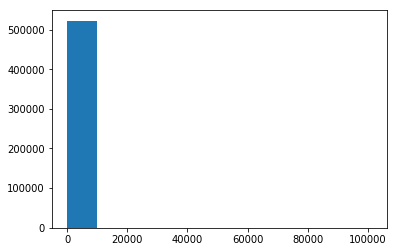

In [31]:
histodata = df
_ = plt.hist(histodata['count'])

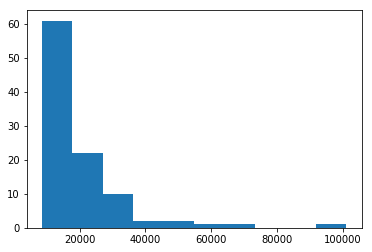

In [32]:
histodata = df.head(100)
_ = plt.hist(histodata['count'])

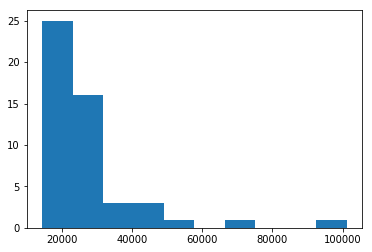

In [33]:
histodata = df.head(50)
_ = plt.hist(histodata['count'])

# Defining the Moods

### Mood Categories

The moods and categories we use are based on the mapping found in the paper ["Lyric Text Mining in Music Mood Classification"](http://www.ismir2009.ismir.net/proceedings/PS3-4.pdf).

H. Xiao, J. S. Downie, and A. F. Ehmann, “Lyric TextMining in Music Mood Classiﬁcation,” American Mu-sic, vol. 183, no. 5040, pp. 411–416, 2009



In [34]:
from label_lyrics import MOOD_CATEGORIES
print('Number of Mood Categories = {0}\n'.format(len(MOOD_CATEGORIES)))
print('Categories:\n')
pprint(MOOD_CATEGORIES)

Number of Mood Categories = 18

Categories:

{'aggression': ['aggression', 'aggressive'],
 'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
 'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
 'brooding': ['brooding', 'contemplative', 'meditative', 'reflective'],
 'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill out'],
 'cheerful': ['cheerful', 'cheer up', 'festive', 'jolly', 'jovial', 'merry'],
 'confident': ['confident', 'encouraging', 'encouragement', 'optimism'],
 'depressed': ['depressed', 'blue', 'dark', 'depressive', 'dreary'],
 'desire': ['desire', 'hope', 'hopeful', 'mood: hopeful'],
 'dreamy': ['dreamy'],
 'earnest': ['earnest', 'heartfelt'],
 'excitement': ['excitement', 'exciting', 'exhilarating', 'thrill', 'ardor'],
 'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
 'happy': ['happy', 'happiness', 'happy songs', 'happy music'],
 'pessimism': ['pessimism', 'cynical', 'pessimistic', 'weltschmerz'],
 'rom

### Expanding the Categories

The last.fm dataset is generated by users without scientific rigor in mind. There is a chance that searching for an exact match on a mood and its related moods will not always yield all possible matches. In this section, we will explore additional tags that match with each category.

For each mood, we
1. Query all tracks that match exactly with the mood and its siblings
2. Query all tracks that match with LIKE the mood and its siblings with some small modifications if necessary (ex: instead of an exact match on 'meditation', we query for a LIKE match on 'meditat' to allow for different conjugations)
3. Compare the difference between (1) and (2)
4. Manually build a set of filters to remove tags that match (2) but are not appropriate. (ex: 'happy' ~= 'unhappy' but is not appropriate)


In [35]:
# to store all filter words for each mood
filters = dict()
# to store all like-query words for each mood
likes = dict()

def match_tags_to_songs(tags, conn):
    """
    Helper function to get all songs that match a group of tags
    """
    sql = ("SELECT tids.tid, tags.tag, tid_tag.val "
           "FROM tid_tag, tids, tags "
           "WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND (")
    last = len(tags)
    for i, tag in enumerate(tags):
        sql += "tags.tag='{0}' ".format(tag)
        if i + 1 != last:
            sql += 'OR '
    sql += ')'
    df = pd.read_sql_query(sql, conn)
    return df

def match_like_tags_to_songs(tags, conn):
    """
    Helper function to get all songs that match with 'LIKE' a group of tags
    """
    sql = ("SELECT tids.tid, tags.tag, tid_tag.val "
           "FROM tid_tag, tids, tags "
           "WHERE tids.ROWID=tid_tag.tid AND tid_tag.tag=tags.ROWID AND (")
    last = len(tags)
    for i, tag in enumerate(tags):
        sql += "tags.tag LIKE '%{0}%' ".format(tag)
        if i + 1 != last:
            sql += 'OR '
    sql += ')'
    df = pd.read_sql_query(sql, conn)
    return df

def set_difference(pd_series1, pd_series2):
    set_diff = set(pd_series1.unique()) - set(pd_series2.unique())
    return set_diff

def filter_by_substring(df, filters):
    for filt in filters:
        df = df[~df.tag.str.lower().str.contains(filt)]
    return df

def like_match_analysis(tags, likes, conn, filters=None):
    """
    Helper function to query and then compare the difference between the two
    query methods
    """
    df_exact = match_tags_to_songs(tags, conn)
    df_like = match_like_tags_to_songs(likes, conn)
    print('Number of songs that are a direct match:', len(df_exact))
    print('Number of songs that are an approximate match:', len(df_like))
    if filters:
        df_like = filter_by_substring(df_like, filters)
        print('\tafter filter:', len(df_like))
    print('\nExample tags covered by the approximate match and not by the direct match:\n')
    set_diff = set_difference(df_like.tag, df_exact.tag)
    print(list(set_diff)[:10])
    pct_improve = -1
    if len(df_exact) > 0:
        pct_improve = len(df_like) / len(df_exact) * 100
    print('\nImprovement granted by like match: {0} songs, {1:.2f}%'.format(
        len(df_like) - len(df_exact), pct_improve))
    
    return df_exact, df_like, set_diff

#### Aggression

In [36]:
likes['aggression'] = ['aggress']

_, _, _ = like_match_analysis(
    MOOD_CATEGORIES['aggression'],
    likes['aggression'],
    conn)

Number of songs that are a direct match: 1656
Number of songs that are an approximate match: 2428

Example tags covered by the approximate match and not by the direct match:

['kinda aggressive', 'aggressive voice', 'aggressive depression', 'calm song aggressive voice', 'chill-to-aggressive', 'for aggressive days', 'makes me aggressive', 'melodically aggressive', 'phil-aggressive', 'aggressive metal']

Improvement granted by like match: 772 songs, 146.62%


Wow! The LIKE search uncovered a lot of missing tags. However, there are some that do not fit the bill. Reviewing the above list, we see the following that should not be included as part of Aggressive. These will be manually culled.

* 'not so aggressive'
* 'aggressio'

In [37]:
filters['aggression'] = ['not so aggressive']

_, _, _ = like_match_analysis(
    MOOD_CATEGORIES['aggression'],
    likes['aggression'],
    conn,
    filters=filters['aggression'])

Number of songs that are a direct match: 1656
Number of songs that are an approximate match: 2428
	after filter: 2426

Example tags covered by the approximate match and not by the direct match:

['kinda aggressive', 'aggressive voice', 'aggressive depression', 'calm song aggressive voice', 'chill-to-aggressive', 'for aggressive days', 'makes me aggressive', 'melodically aggressive', 'phil-aggressive', 'aggressive metal']

Improvement granted by like match: 770 songs, 146.50%


#### Anger

In [38]:
likes['anger'] = ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['anger'],
    likes['anger'],
    conn)

Number of songs that are a direct match: 3158
Number of songs that are an approximate match: 21928

Example tags covered by the approximate match and not by the direct match:

['played with Average White Band', 'angry intervention', 'encouraged', 'composer-arranger', 'slow garagedancing', 'etranger', 'let your rage grow', 'im angry leave me alone', 'obscure anger', 'deep garage']

Improvement granted by like match: 18770 songs, 694.36%


In [39]:
# we can see that there are many tags that do not fit in with 'anger'
# we attempt to filter those out here for a better look
filters['anger'] = ['garage', 'entourage', 'daranger', 'danger', 'underage', 'banger',
          'ranger', 'doppleganger', 'doppelganger', 'traged', 'piangere', 'stranger',
          'beverage', 'coverage', 'zangeres', 'average', 'mirage', 'underage',
          'langer', 'not in anger', 'tanger', 'fuleragem', 'fragements', 'enouragement',
          'suffragette', 'avarage', 'leverage', 'changer', 'courage', 'hervorragend', 
          'bursdagsanger', 'tragedies', 'rage against the machine', 'volkzangers',
          'getragen', 'frageze', 'tanger', 'arragem', 'not rage', 'wangerFamilie',
          'cooperage', 'anchorage', 'sanger', 'manger', 'sangerin', 'kenneth anger',
          'svanger', 'songs that take all the anger out of you', 'pandeiragem', 'behangers',
          'fragen', 'angerls', 'frage', 'korageklimper', 'sjanger', 'umbrageous']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['anger'],
    likes['anger'],
    conn,
    filters=filters['anger'])

Number of songs that are a direct match: 3158
Number of songs that are an approximate match: 21928
	after filter: 5968

Example tags covered by the approximate match and not by the direct match:

['Angry Ass-Kicking Masheeen', 'angry sex music', 'angry intervention', 'anger management', 'My Angry Song', 'let your rage grow', 'angry depressed dance music', 'im angry leave me alone', 'obscure anger', 'im angry too i get it']

Improvement granted by like match: 2810 songs, 188.98%


#### Angst

In [40]:
likes['angst'] = ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['angst'],
    likes['angst'],
    conn)    

Number of songs that are a direct match: 1213
Number of songs that are an approximate match: 5488

Example tags covered by the approximate match and not by the direct match:

['feel anxiety', 'gangsta bounce', 'oh the angst', 'adolescent angst', 'nervousbreakdown', 'gestoerte depressive cracknutten mit hippiekomplexen aufgewachsen in einer destruktiv-kapitalistischen umwelt mit der staendigen angst vor der atombombe', 'my teen angst soundtrack', 'gangsta ass shit', 'gangsta tune', 'Angsty Chicks on Piano']

Improvement granted by like match: 4275 songs, 452.43%


In [41]:
filters['angst'] = ['gangst', 'langstrumpf', 'farangstar', 'gaaangstaa', 'klangstark', ]

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['angst'],
    likes['angst'],
    conn,
    filters=filters['angst'])    

Number of songs that are a direct match: 1213
Number of songs that are an approximate match: 5488
	after filter: 1912

Example tags covered by the approximate match and not by the direct match:

['feel anxiety', 'oh the angst', 'adolescent angst', 'melancholic but still not quite angsty', 'jumpy dance', 'collegeangst', 'anxiety sadness', 'anxiousness', 'gestoerte depressive cracknutten mit hippiekomplexen aufgewachsen in einer destruktiv-kapitalistischen umwelt mit der staendigen angst vor der atombombe', 'nervousbreakdown']

Improvement granted by like match: 699 songs, 157.63%


#### Brooding

In [42]:
likes['brooding'] = ['brood', 'contemplat', 'meditat', 'reflect']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['brooding'],
    likes['brooding'],
    conn)    

Number of songs that are a direct match: 1360
Number of songs that are an approximate match: 5443

Example tags covered by the approximate match and not by the direct match:

['Memories Dreams Reflections', 'Reflection Eternal', 'HYPNO-TRANCE-MEDITATON', 'the sisters of mercy- lucretia my reflection', 'meditation2', 'dark meditative beauty', 'meditation osho', 'seashore meditation', 'meditational greek', 'harold budd-meditation']

Improvement granted by like match: 4083 songs, 400.22%


In [43]:
filters['brooding'] = ['broodcast', 'marilyn manson - the reflecting god', 'silverchair-reflections of a sound']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['brooding'],
    likes['brooding'],
    conn,
    filters=filters['brooding'])   

Number of songs that are a direct match: 1360
Number of songs that are an approximate match: 5443
	after filter: 5439

Example tags covered by the approximate match and not by the direct match:

['Memories Dreams Reflections', 'Reflection Eternal', 'HYPNO-TRANCE-MEDITATON', 'the sisters of mercy- lucretia my reflection', 'meditation2', 'dark meditative beauty', 'meditation osho', 'seashore meditation', 'meditational greek', 'harold budd-meditation']

Improvement granted by like match: 4079 songs, 399.93%


#### Calm

In [44]:
likes['calm'] = ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['calm'],
    likes['calm'],
    conn)   

Number of songs that are a direct match: 10785
Number of songs that are an approximate match: 142518

Example tags covered by the approximate match and not by the direct match:

['mellow distortion', 'calm beauty', 'chillout synth', 'chillvoice', 'Piehti - Chilldub', 'highender future chillouter lounge', 'discomfort', 'Chillingly nice', 'dope chilled rap', 'chillerei']

Improvement granted by like match: 131733 songs, 1321.45%


In [45]:
filters['calm'] = ['calminha', 'schill-das', 'dragonland', 'clelia felix', 'schiller', 'quiet riot',
          'chillung', 'alex gopher', 'royksoppia', 'bob baldwin', 'uncomfortabl',
          'chili con carnage', 'hot as chilli', 'smokey robinson', 'quiet roit', 
          'grover washington', 'stvari', 'mobb deep', 'scott matthews', 'shadow puppets',
          'red hot chilli pipers', 'feeder-2002', 'piehti', 'peter schilling',
          'the main ingredient', 'red hot chilli pepper', 'impossible to listen to quietly',
          'cannot be played quietly', 'probably have listened to the chills', 'rustycanuckchill',
          'southern comfort', 'most serene republic', 'john mayer', 'nusrat fateh', 'pink martini',
          'skunk anansie', 'tonight is glory', 'brutal metal for quiet people', 'calmeback',
          'red hot chilli pepers', 'comfort food', 'chilli peppers', 'comfortably numb',
          'simon cooper', 'redhotchillypeppers', 'the sea is calm once more', 'paul brown',
          'maria mena', 'chilli pepers', 'comfortable liar', 'unrequieted', 'carly simon',
          'shai', 'quietdrive', 'red hot chillis', 'buddha-bar', 'discomfort',
          'red hot chilly pepers', 'children of bodom', 'not calming']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['calm'],
    likes['calm'],
    conn,
    filters=filters['calm'])

Number of songs that are a direct match: 10785
Number of songs that are an approximate match: 142518
	after filter: 142048

Example tags covered by the approximate match and not by the direct match:

['mellow distortion', 'calm beauty', 'chillout synth', 'chillvoice', 'highender future chillouter lounge', 'Chillingly nice', 'dope chilled rap', 'chillerei', 'buddha bar- chillout', 'chillology']

Improvement granted by like match: 131263 songs, 1317.09%


#### Cheerful

In [46]:
likes['cheerful'] = ['cheer', 'festive', 'jolly', 'jovial', 'merry']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['cheerful'],
    likes['cheerful'],
    conn)

Number of songs that are a direct match: 1395
Number of songs that are an approximate match: 4920

Example tags covered by the approximate match and not by the direct match:

['cheer up girl', 'if i was a cheerleader i would cheer this forever', 'make me cheerful', 'cheer up teacup', 'john peels festive 50 1977', 'cheerleader pop', 'cheer up bitch', 'cheery la de la', 'cutely cheerful', 'jolly joker']

Improvement granted by like match: 3525 songs, 352.69%


In [47]:
filters['cheerful'] = ['cheerlead', 'samples jolly roger', 'pretty depressing', 'cheerless', 'Sophie Merry']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['cheerful'],
    likes['cheerful'],
    conn,
    filters=filters['cheerful'])

Number of songs that are a direct match: 1395
Number of songs that are an approximate match: 4920
	after filter: 4819

Example tags covered by the approximate match and not by the direct match:

['cheer up girl', 'make me cheerful', 'cheer up teacup', 'john peels festive 50 1977', 'cheer up bitch', 'cheery la de la', 'cutely cheerful', 'jolly joker', 'merry xmas from slade', 'merrypinkbunnies']

Improvement granted by like match: 3424 songs, 345.45%


#### Confident

In [48]:
likes['confident'] = ['confident', 'encourag', 'optimis']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['confident'],
    likes['confident'],
    conn)   

Number of songs that are a direct match: 247
Number of songs that are an approximate match: 1612

Example tags covered by the approximate match and not by the direct match:

['optimistic chillout', 'encouragement machine', 'candide or the optimist', 'encouraged', 'High School Confidential', 'optimismo', 'mood classical optimism', 'self-confident', 'poptimist', 'mood encouraging']

Improvement granted by like match: 1365 songs, 652.63%


In [49]:
filters['confident'] = ['confidential']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['confident'],
    likes['confident'],
    conn,
    filters=filters['confident'])   

Number of songs that are a direct match: 247
Number of songs that are an approximate match: 1612
	after filter: 1604

Example tags covered by the approximate match and not by the direct match:

['optimistic chillout', 'encouragement machine', 'candide or the optimist', 'encouraged', 'optimismo', 'mood classical optimism', 'self-confident', 'poptimist', 'mood encouraging', 'a song for optimists']

Improvement granted by like match: 1357 songs, 649.39%


#### Depressed

In [50]:
likes['depressed'] = ['depress', 'dark', 'drear']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['depressed'],
    # removed blue as it returned far more negative hits than positive
    likes['depressed'],
    conn)   

Number of songs that are a direct match: 9522
Number of songs that are an approximate match: 36328

Example tags covered by the approximate match and not by the direct match:

['dark deep drum and bass drum-and-bass dnb', 'darkness', 'out of the dark nice 1', 'dark electro girl', 'predepression', 'dark punk', 'songs that depress me', 'light depression', 'Depressing soft rock', 'dark romance']

Improvement granted by like match: 26806 songs, 381.52%


In [51]:
filters['depressed'] = ['billy squier', 'david benoit', 'dark alley', 'john fogerty', 'jacks mannequin',
          'naglfar', 'brenda russell', 'uncle tupelo', 'omarion', 'ozzy osbourne',
          'donnie darko', 'donny darko', 'its dark outside', 'julenzeit', 'the hoosiers',
          'black shuck', 'hot chip', 'mary gauthier', 'zombie girl', 'tuna sandwiches',
          'dark sky demo', 'macbeth', 'poisonblack', 'oxide and neutrino', 
          'motion picture soundtrack', ]

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['depressed'],
    # removed blue as it returned far more negative hits than positive
    likes['depressed'],
    conn,
    filters=filters['depressed'])   

#pd.options.display.max_rows = 4000
#pd.Series(list(set_diff)).sort_values()

Number of songs that are a direct match: 9522
Number of songs that are an approximate match: 36328
	after filter: 36249

Example tags covered by the approximate match and not by the direct match:

['dark deep drum and bass drum-and-bass dnb', 'darkness', 'out of the dark nice 1', 'dark electro girl', 'predepression', 'dark punk', 'songs that depress me', 'light depression', 'Depressing soft rock', 'dark romance']

Improvement granted by like match: 26727 songs, 380.69%


#### Desire

In [52]:
likes['desire'] = ['desire', 'desirin', 'hope', 'hopin']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['desire'],
    likes['desire'],
    conn)   

Number of songs that are a direct match: 576
Number of songs that are an approximate match: 2850

Example tags covered by the approximate match and not by the direct match:

['Alternative RockIndie RockIndiePopRockBritishPsychedelicFolkScottishIndie PopAlternativeTrip-HopElectronicExperimentalPost-Rock', 'industry hope of states', 'glory hope mountain', 'Last Hope', 'the new hope in the footsteps of Leather Strip or Psychopomps', 'DowntempoJazzFemale VocalistsScandinavianNorwegianSinger-SongwriterAlternativeTrip-HopElectronicChillout', 'i hope i can and do someday find somebody who makes me feel this way', 'i was hoping', 'all hope is gone', 'fresh prince style rap over the verses leaves a bit to be desired though']

Improvement granted by like match: 2274 songs, 494.79%


In [53]:
filters['desire'] = ['hope of the states mix', 'hopelorn', 'you hope that he get what', 'trip-hop', 'hope sandoval',
          'hopeless', 'swallow the sun', 'trip hop', 'hopelessness', 'chopin', 'the white ship of hope', 'no hope',
          'hope is gone', 'hopeton', 'hip-hope', 'james hope', 'hoperas', 'randy hope', 'falsehope', 'i hope not',
          'rapid hope loss', 'hopek', 'give up all hope', 'barbershopesque', 'miridesire', 'i hope my neighbour',
          'pirates of the caribbean']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['desire'],
    likes['desire'],
    conn,
    filters=filters['desire'])

Number of songs that are a direct match: 576
Number of songs that are an approximate match: 2850
	after filter: 2350

Example tags covered by the approximate match and not by the direct match:

['industry hope of states', 'glory hope mountain', 'Last Hope', 'the new hope in the footsteps of Leather Strip or Psychopomps', 'i hope i can and do someday find somebody who makes me feel this way', 'i was hoping', 'fresh prince style rap over the verses leaves a bit to be desired though', 'to be strong to keep calm and to trust they were still the one hope', 'hope of the states me ves y sufres', 'symbol of new hope']

Improvement granted by like match: 1774 songs, 407.99%


#### Dreamy

In [54]:
likes['dreamy'] = ['dreamy']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['dreamy'],
    likes['dreamy'],
    conn)

Number of songs that are a direct match: 0
Number of songs that are an approximate match: 7487

Example tags covered by the approximate match and not by the direct match:

['Dreamy Bucharest', 'dreamy calming songs', 'romantic gorgeous dreamy', 'dreamysweet', 'dreamy folk', 'dreamy sound', 'english dreamy', 'ethnic sax dreamy', 'dreamy synthpop', 'most dreamy']

Improvement granted by like match: 7487 songs, -1.00%


In [55]:
filters['dreamy'] = ['wasnt jake dreamy', 'val kilmer is dreamy', 'alex james', 'roots manuva']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['dreamy'],
    likes['dreamy'],
    conn,
    filters=filters['dreamy'])

Number of songs that are a direct match: 0
Number of songs that are an approximate match: 7487
	after filter: 7480

Example tags covered by the approximate match and not by the direct match:

['Dreamy Bucharest', 'dreamy calming songs', 'romantic gorgeous dreamy', 'dreamysweet', 'dreamy folk', 'dreamy sound', 'english dreamy', 'ethnic sax dreamy', 'dreamy synthpop', 'most dreamy']

Improvement granted by like match: 7480 songs, -1.00%


#### Earnest

In [56]:
# extra synonyms gathered from google "earnest synonyms"
likes['earnest'] = ['earnest', 'heartfelt'] + ['devout', 'wholeheart', 'sincere', 'impassion', 'fervent', 'ardent']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['earnest'],
    likes['earnest'],
    conn)   

Number of songs that are a direct match: 509
Number of songs that are an approximate match: 923

Example tags covered by the approximate match and not by the direct match:

['sincerety', 'brand nubian - sincerely', 'heartfelt punk', 'Sincerely me darling', 'just what made our encounters so sincere', 'sincere ones', 'love songs for the foolhardy and earnest', 'brutally sincere nostalgia', 'Monneglows - Sincerely', 'more genuine and heartfelt than a thousand introverted and whiny pop songs']

Improvement granted by like match: 414 songs, 181.34%


In [57]:
filters['earnest'] = ['fervent qawwali', 'sincerely frightening', 'not sincere', 'sincere mj cole nero rmx',
          'brand nubian', 'i would clap', 'insincere', 'monneglows', 'sri radha', 'new found glory']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['earnest'],
    likes['earnest'],
    conn,
    filters=filters['earnest'])


Number of songs that are a direct match: 509
Number of songs that are an approximate match: 923
	after filter: 898

Example tags covered by the approximate match and not by the direct match:

['sincerety', 'sincerely', 'lyrically beautiful and heartfelt', 'heartfelt punk', 'heartfelt conversations', 'Sincerely me darling', 'HEARTFELT SHIT', 'just what made our encounters so sincere', 'sincere ones', 'fervent']

Improvement granted by like match: 389 songs, 176.42%


#### Excitement

In [58]:
likes['excitement'] = ['excite', 'exhilarating', 'thrill', 'ardor']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['excitement'],
    likes['excitement'],
    conn)   

Number of songs that are a direct match: 532
Number of songs that are an approximate match: 1071

Example tags covered by the approximate match and not by the direct match:

['fixin to thrill', 'The Thrills - Just Travelling Through - The Everlasting', 'thrilling cover version', 'pumped but not to excited', 'geezers need excitement', 'indie hardore', 'md-thriller', 'LilKens thrills', 'Exciter', 'so excited']

Improvement granted by like match: 539 songs, 201.32%


In [59]:
filters['excitement'] = ['juat travelling through', 'tardor', 'excited for full album', 'michael jackson', 'richardor',
          'thrilla riddim', 'hardore', 'the pointer sisters', 'the thrills', 'in his excitement', 
          'jagged edge', 'the theme', 'thrill is gone', 'thrillseekers', 'fall out boy']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['excitement'],
    likes['excitement'],
    conn,
    filters=filters['excitement'])


Number of songs that are a direct match: 532
Number of songs that are an approximate match: 1071
	after filter: 964

Example tags covered by the approximate match and not by the direct match:

['fixin to thrill', 'thrilling cover version', 'thrill kill', 'perrys-stillthrilled', 'musical thriller', 'pumped but not to excited', 'geezers need excitement', '1950s thriller', 'thrillies', 'thrills down my spine']

Improvement granted by like match: 432 songs, 181.20%


#### Grief

In [60]:
likes['grief'] = ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['grief'],
    likes['grief'],
    conn)   

Number of songs that are a direct match: 1909
Number of songs that are an approximate match: 4896

Example tags covered by the approximate match and not by the direct match:

['beautiful painfully romantic heartbreaking  god-like melancholic inspiring best song of all times', 'sing the sorrow', 'so sorry', 'private sorrow', 'the word sorrow', 'the old grief', 'mournful violin', 'Be a Heartbreaker', 'moonsorrow grandes miticos', 'Charon-Sorrowbringer']

Improvement granted by like match: 2987 songs, 256.47%


In [61]:
# a lot of artists have written songs with the word "sorry" in the title...
filters['grief'] = ['the heartbreakers', '1st album', 'femi kuti', 'glenn jones', 'brenda lee',
          'kenny g', 'kings of convenience', 'madonna', 'maria mena', 'markus schulz',
          'matt wertz', 'mcfly', 'moonsorrow', 'mustard plug', 'my chemical romance',
          'pat benatar', 'paul cardall', 'jonas brothers', 'ferry corsten',
          'taylor swift', 'ted leo', 'not sorry', 'impalas', 'pillows',
          'whitney houston', 'calvin johnston', 'jackson browne', 'johnny cash', ]

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['grief'],
    likes['grief'],
    conn,
    filters=filters['grief'])

Number of songs that are a direct match: 1909
Number of songs that are an approximate match: 4896
	after filter: 4738

Example tags covered by the approximate match and not by the direct match:

['beautiful painfully romantic heartbreaking  god-like melancholic inspiring best song of all times', 'sing the sorrow', 'so sorry', 'private sorrow', 'the word sorrow', 'the old grief', 'mournful violin', 'Be a Heartbreaker', 'Charon-Sorrowbringer', 'sorrow-filled']

Improvement granted by like match: 2829 songs, 248.19%


#### Happy

In [62]:
likes['happy'] = ['happy', 'happiness']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['happy'],
    likes['happy'],
    conn)   

Number of songs that are a direct match: 13069
Number of songs that are an approximate match: 28106

Example tags covered by the approximate match and not by the direct match:

['clap-happy whoo', 'happy is a mediocre existance', 'Acoustic Makes Me Happy', 'This makes me so fucking happy', 'happy sappy crapola', 'colleen - sometimes on a happy cloud from everyone alive wants', 'Happy Birthday Dear Heartache', 'happy sofas', 'making happy', 'make me feel happy']

Improvement granted by like match: 15037 songs, 215.06%


In [63]:
filters['happy'] = ['al green', 'altered image', 'angelique', 'avril lavigne', 'bert kaempfert',
          'black uhuru', 'bud powell trio', 'cloudy', 'enrico rava', 'edwin hawkins singers',
          'faith evans', 'garbage', 'tim hughes', 'kotaro oshio', 'junior jack', 'jill cunniff',
          'modeselektor', 'phillip walker', 'siouxsie and the banshees', 'snow patrol', 
          'all-american rejects', 'all american rejects', 'the cure', 'tomas andersson',
          'neil sedaka', 'happy feet soundtrack', 'happy gilmore', 'not happy']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['happy'],
    likes['happy'],
    conn,
    filters=filters['happy'])


Number of songs that are a direct match: 13069
Number of songs that are an approximate match: 28106
	after filter: 28011

Example tags covered by the approximate match and not by the direct match:

['clap-happy whoo', 'happy is a mediocre existance', 'Acoustic Makes Me Happy', 'This makes me so fucking happy', 'happy sappy crapola', 'colleen - sometimes on a happy cloud from everyone alive wants', 'Happy Birthday Dear Heartache', 'happy sofas', 'making happy', 'make me feel happy']

Improvement granted by like match: 14942 songs, 214.33%


#### Pessimism

In [64]:
likes['pessimism'] = ['pessimis', 'cynic', 'weltschmerz']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['pessimism'],
    likes['pessimism'],
    conn)   

Number of songs that are a direct match: 37
Number of songs that are an approximate match: 982

Example tags covered by the approximate match and not by the direct match:

['cynical-sarcastic', 'cynical lovesong', 'Mr Weltschmerz', 'mypessimistictimes', 'the sound of my cynicism melting', 'cheery pessimism', 'Cynical', 'cynic', 'uplifting for cynics', 'hilariously pessimistic']

Improvement granted by like match: 945 songs, 2654.05%


In [65]:
filters['pessimism'] = ['veil of maya', 'marshal crenshaw']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['pessimism'],
    likes['pessimism'],
    conn,
    filters=filters['pessimism'])


Number of songs that are a direct match: 37
Number of songs that are an approximate match: 982
	after filter: 980

Example tags covered by the approximate match and not by the direct match:

['cynical-sarcastic', 'cynical lovesong', 'Mr Weltschmerz', 'mypessimistictimes', 'the sound of my cynicism melting', 'cheery pessimism', 'Cynical', 'cynic', 'uplifting for cynics', 'hilariously pessimistic']

Improvement granted by like match: 943 songs, 2648.65%


#### Romantic

In [66]:
likes['romantic'] = ['romant']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['romantic'],
    likes['romantic'],
    conn)   

Number of songs that are a direct match: 9448
Number of songs that are an approximate match: 18283

Example tags covered by the approximate match and not by the direct match:

['beautiful painfully romantic heartbreaking  god-like melancholic inspiring best song of all times', 'romantic piano greats', 'romantic gorgeous dreamy', 'Romantic Classics', 'electro-pop romantico', 'lastfm new romantics member radio', 'romantic metal', 'romantic 80s lovesong', 'Romantic Mushy Heartbreak Pop Girlband', 'Musica Romantica xD']

Improvement granted by like match: 8835 songs, 193.51%


In [67]:
filters['romantic'] = ['ace of base', 'aiden', 'ana gabriel', 'romantic warrior', 'nekromantix',
          'negromantix', 'romantic worrior', 'the swan romantic', 'necromanti',
          'nekromanti', 'phil collins', ]

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['romantic'],
    likes['romantic'],
    conn,
    filters=filters['romantic'])


Number of songs that are a direct match: 9448
Number of songs that are an approximate match: 18283
	after filter: 18239

Example tags covered by the approximate match and not by the direct match:

['beautiful painfully romantic heartbreaking  god-like melancholic inspiring best song of all times', 'romantic piano greats', 'romantic gorgeous dreamy', 'Romantic Classics', 'electro-pop romantico', 'lastfm new romantics member radio', 'romantic metal', 'romantic 80s lovesong', 'Romantic Mushy Heartbreak Pop Girlband', 'Musica Romantica xD']

Improvement granted by like match: 8791 songs, 193.05%


#### Sad

In [68]:
likes['sad'] = ['sad', 'unhappy', 'melanchol']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['sad'],
    likes['sad'],
    conn)   

Number of songs that are a direct match: 21115
Number of songs that are an approximate match: 49104

Example tags covered by the approximate match and not by the direct match:

['sadly staring at the rain', 'jazz melancholy cool', 'sadest tracks', 'im going to die alone and sad', 'Sade - Turn Ly Back On You', 'Melancholic Folk', 'feel melancholic', 'the smashing pumpkins infinite sadness', 'a little melancholy', 'upland AKA song that makes me sad']

Improvement granted by like match: 27989 songs, 232.56%


In [69]:
filters['sad'] = ['crusade', 'cat stevens', 'sadie', 'cansado', 'palisades', 'ablusado',
          'sadist', 'pasad', 'sade', 'pesad', 'masada', 'all-american rejects',
          'prasad', 'sadventure', 'sadiddy', 'chris garneau', 'the ataris',
          'moody blues', 'toni braxton', 'casada', 'incubus', 'nick cave', 
          'ryan cabrera', 'wayne wonder', 'cassady']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['sad'],
    likes['sad'],
    conn,
    filters=filters['sad'])


Number of songs that are a direct match: 21115
Number of songs that are an approximate match: 49104
	after filter: 48269

Example tags covered by the approximate match and not by the direct match:

['slow motion melancholy', 'SADNESS AND THE CITY', 'love sad song', 'strangely sad', 'sadly staring at the rain', 'why so sad', 'twinkly melancholy', 'cosy melancholia', 'jazz melancholy cool', 'melancholie']

Improvement granted by like match: 27154 songs, 228.60%


#### Upbeat

In [70]:
likes['upbeat'] = ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusias']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['upbeat'],
    likes['upbeat'],
    conn)   

Number of songs that are a direct match: 9569
Number of songs that are an approximate match: 11570

Example tags covered by the approximate match and not by the direct match:

['fun and upbeat', 'french upbeat', 'All-time Upbeat', 'fast and upbeat', 'upbeat-chill', 'Classic upbeat', 'Kick ass upbeat Third-wave ska revival', 'zestfunk', 'songs with upbeat music but serious lyrics', 'Relaxing upbeat']

Improvement granted by like match: 2001 songs, 120.91%


In [71]:
filters['upbeat'] = ['too upbeat', 'lemon zest', 'niemogeprzestacsluchac', 'zestcooooooool',
          'zestfunk', 'zesthop', 'zestig', 'zestjazzy', 'zestoko', 'zestpsy',
          'zestteuf']

df_exact, df_like, set_diff = like_match_analysis(
    MOOD_CATEGORIES['upbeat'],
    likes['upbeat'],
    conn,
    filters=filters['upbeat'])


Number of songs that are a direct match: 9569
Number of songs that are an approximate match: 11570
	after filter: 11225

Example tags covered by the approximate match and not by the direct match:

['fun and upbeat', 'french upbeat', 'All-time Upbeat', 'fast and upbeat', 'upbeat-chill', 'Classic upbeat', 'Kick ass upbeat Third-wave ska revival', 'songs with upbeat music but serious lyrics', 'Relaxing upbeat', 'Mood  SOUNDS like upbeat fun']

Improvement granted by like match: 1656 songs, 117.31%


### Introducing MOOD_CATEGORIES_EXPANDED

We now have a set of filters for each and a new set of like-queries for each mood. With this information, we can construct a new, expanded MOOD_CATEGORIES dictionary to increase the size of our dataset.

In [72]:
filters

{'aggression': ['not so aggressive'],
 'anger': ['garage',
  'entourage',
  'daranger',
  'danger',
  'underage',
  'banger',
  'ranger',
  'doppleganger',
  'doppelganger',
  'traged',
  'piangere',
  'stranger',
  'beverage',
  'coverage',
  'zangeres',
  'average',
  'mirage',
  'underage',
  'langer',
  'not in anger',
  'tanger',
  'fuleragem',
  'fragements',
  'enouragement',
  'suffragette',
  'avarage',
  'leverage',
  'changer',
  'courage',
  'hervorragend',
  'bursdagsanger',
  'tragedies',
  'rage against the machine',
  'volkzangers',
  'getragen',
  'frageze',
  'tanger',
  'arragem',
  'not rage',
  'wangerFamilie',
  'cooperage',
  'anchorage',
  'sanger',
  'manger',
  'sangerin',
  'kenneth anger',
  'svanger',
  'songs that take all the anger out of you',
  'pandeiragem',
  'behangers',
  'fragen',
  'angerls',
  'frage',
  'korageklimper',
  'sjanger',
  'umbrageous'],
 'angst': ['gangst', 'langstrumpf', 'farangstar', 'gaaangstaa', 'klangstark'],
 'brooding': ['bro

In [73]:
likes

{'aggression': ['aggress'],
 'anger': ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
 'angst': ['angst', 'anxiety', 'anxious', 'jumpy', 'nervous', 'angsty'],
 'brooding': ['brood', 'contemplat', 'meditat', 'reflect'],
 'calm': ['calm', 'comfort', 'quiet', 'serene', 'mellow', 'chill'],
 'cheerful': ['cheer', 'festive', 'jolly', 'jovial', 'merry'],
 'confident': ['confident', 'encourag', 'optimis'],
 'depressed': ['depress', 'dark', 'drear'],
 'desire': ['desire', 'desirin', 'hope', 'hopin'],
 'dreamy': ['dreamy'],
 'earnest': ['earnest',
  'heartfelt',
  'devout',
  'wholeheart',
  'sincere',
  'impassion',
  'fervent',
  'ardent'],
 'excitement': ['excite', 'exhilarating', 'thrill', 'ardor'],
 'grief': ['grief', 'heartbreak', 'mournful', 'sorrow', 'sorry'],
 'happy': ['happy', 'happiness'],
 'pessimism': ['pessimis', 'cynic', 'weltschmerz'],
 'romantic': ['romant'],
 'sad': ['sad', 'unhappy', 'melanchol'],
 'upbeat': ['upbeat', 'gleeful', 'high spirits', 'zest', 'enthusias

In [74]:
mood_categories_expanded = dict()

for mood, exact_queries in MOOD_CATEGORIES.items():
    mood_categories_expanded[mood] = [exact_queries, likes[mood], filters[mood]]

pprint(mood_categories_expanded)

{'aggression': [['aggression', 'aggressive'],
                ['aggress'],
                ['not so aggressive']],
 'anger': [['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
           ['anger', 'angry', 'choleric', 'fury', 'outraged', 'rage'],
           ['garage',
            'entourage',
            'daranger',
            'danger',
            'underage',
            'banger',
            'ranger',
            'doppleganger',
            'doppelganger',
            'traged',
            'piangere',
            'stranger',
            'beverage',
            'coverage',
            'zangeres',
            'average',
            'mirage',
            'underage',
            'langer',
            'not in anger',
            'tanger',
            'fuleragem',
            'fragements',
            'enouragement',
            'suffragette',
            'avarage',
            'leverage',
            'changer',
            'courage',
            'hervorragend',
            'bur

In [75]:
# save as json
with open('mood_categories_expanded.json', 'w') as outfile:
    json.dump(mood_categories_expanded, outfile, indent=4, sort_keys=True)

# did we write it correctly?
from label_lyrics import read_mood_categories_expanded
read_data = read_mood_categories_expanded()

mood_categories_expanded == read_data

True

In [76]:
from label_lyrics import label_lyrics, CSV_LABELED_LYRICS
from index_lyrics import CSV_INDEX_LYRICS

label_lyrics(
    csv_input=CSV_INDEX_LYRICS,
    csv_output='data/labeled_lyrics_lastfm_tags_eda.csv',
    expanded_moods=True)


2018-11-26 14:00:10,049 - INFO: Reading in input csv data/indexed_lyrics.csv
2018-11-26 14:00:10,049 - INFO: Reading in input csv data/indexed_lyrics.csv
2018-11-26 14:00:11,790 - DEBUG: Adding column "mood" to lyrics dataframe
2018-11-26 14:00:11,790 - DEBUG: Adding column "mood" to lyrics dataframe
2018-11-26 14:00:11,794 - DEBUG: Adding column "found_tags" to lyrics dataframe
2018-11-26 14:00:11,794 - DEBUG: Adding column "found_tags" to lyrics dataframe
2018-11-26 14:00:11,796 - DEBUG: Adding column "matched_mood" to lyrics dataframe
2018-11-26 14:00:11,796 - DEBUG: Adding column "matched_mood" to lyrics dataframe
2018-11-26 14:00:11,798 - DEBUG: Filtering to only songs that are in english and have lyrics available
2018-11-26 14:00:11,798 - DEBUG: Filtering to only songs that are in english and have lyrics available
2018-11-26 14:00:11,800 - DEBUG: Songs before filtering: 779056
2018-11-26 14:00:11,800 - DEBUG: Songs before filtering: 779056
2018-11-26 14:00:12,057 - DEBUG: Songs a

2018-11-26 14:00:12,790 - DEBUG: 29, Til_Tuesday___Love_In_A_Vacuum: found tags but could not match mood
2018-11-26 14:00:12,805 - DEBUG: 30, Til_Tuesday___Why_Must_I: found tags but could not match mood
2018-11-26 14:00:12,805 - DEBUG: 30, Til_Tuesday___Why_Must_I: found tags but could not match mood
2018-11-26 14:00:12,820 - DEBUG: 31, Til_Tuesday___Dont_Watch_Me_Bleed: found tags but could not match mood
2018-11-26 14:00:12,820 - DEBUG: 31, Til_Tuesday___Dont_Watch_Me_Bleed: found tags but could not match mood
2018-11-26 14:00:12,853 - DEBUG: 32, Til_Tuesday___The_Other_End_Of_The_Telescope: success! mood=romantic
2018-11-26 14:00:12,853 - DEBUG: 32, Til_Tuesday___The_Other_End_Of_The_Telescope: success! mood=romantic
2018-11-26 14:00:12,871 - DEBUG: 33, Til_Tuesday___J_For_Jules: found tags but could not match mood
2018-11-26 14:00:12,871 - DEBUG: 33, Til_Tuesday___J_For_Jules: found tags but could not match mood
2018-11-26 14:00:12,886 - DEBUG: 34, Til_Tuesday___Sleep: found tags 

2018-11-26 14:00:13,574 - DEBUG: 77, 44___Weatherman: no tags
2018-11-26 14:00:13,574 - DEBUG: 77, 44___Weatherman: no tags
2018-11-26 14:00:13,589 - DEBUG: 78, 44___When_Your_Heart_Stops_Beating: no tags
2018-11-26 14:00:13,589 - DEBUG: 78, 44___When_Your_Heart_Stops_Beating: no tags
2018-11-26 14:00:13,605 - DEBUG: 79, 123min___High_Treason: no tags
2018-11-26 14:00:13,605 - DEBUG: 79, 123min___High_Treason: no tags
2018-11-26 14:00:13,620 - DEBUG: 80, 123min___Im_In_You: no tags
2018-11-26 14:00:13,620 - DEBUG: 80, 123min___Im_In_You: no tags
2018-11-26 14:00:13,635 - DEBUG: 81, 123min___Blue_Sunday: no tags
2018-11-26 14:00:13,635 - DEBUG: 81, 123min___Blue_Sunday: no tags
2018-11-26 14:00:13,650 - DEBUG: 82, 123min___Your_Song: no tags
2018-11-26 14:00:13,650 - DEBUG: 82, 123min___Your_Song: no tags
2018-11-26 14:00:13,665 - DEBUG: 83, 123min___Your_Satellite: no tags
2018-11-26 14:00:13,665 - DEBUG: 83, 123min___Your_Satellite: no tags
2018-11-26 14:00:13,679 - DEBUG: 84, 123min_

2018-11-26 14:00:14,128 - DEBUG: 113, And_You_Will_Know_Us_By_The_Trail_Of_Dead___Another_Morning_Stoner: success! mood=excitement
2018-11-26 14:00:14,155 - DEBUG: 114, And_You_Will_Know_Us_By_The_Trail_Of_Dead___Totally_Natural: found tags but could not match mood
2018-11-26 14:00:14,155 - DEBUG: 114, And_You_Will_Know_Us_By_The_Trail_Of_Dead___Totally_Natural: found tags but could not match mood
2018-11-26 14:00:14,171 - DEBUG: 115, And_You_Will_Know_Us_By_The_Trail_Of_Dead___Flood_Of_Red: found tags but could not match mood
2018-11-26 14:00:14,171 - DEBUG: 115, And_You_Will_Know_Us_By_The_Trail_Of_Dead___Flood_Of_Red: found tags but could not match mood
2018-11-26 14:00:14,186 - DEBUG: 116, And_You_Will_Know_Us_By_The_Trail_Of_Dead___The_Lost_City_Of_Refuge: success! mood=calm
2018-11-26 14:00:14,186 - DEBUG: 116, And_You_Will_Know_Us_By_The_Trail_Of_Dead___The_Lost_City_Of_Refuge: success! mood=calm
2018-11-26 14:00:14,201 - DEBUG: 117, And_You_Will_Know_Us_By_The_Trail_Of_Dead___S

2018-11-26 14:00:14,726 - DEBUG: 152, 10_Years___Prey: success! mood=sad
2018-11-26 14:00:14,726 - DEBUG: 152, 10_Years___Prey: success! mood=sad
2018-11-26 14:00:14,741 - DEBUG: 153, 10_Years___Cast_It_Out: success! mood=sad
2018-11-26 14:00:14,741 - DEBUG: 153, 10_Years___Cast_It_Out: success! mood=sad
2018-11-26 14:00:14,756 - DEBUG: 154, 10_Years___Empires: found tags but could not match mood
2018-11-26 14:00:14,756 - DEBUG: 154, 10_Years___Empires: found tags but could not match mood
2018-11-26 14:00:14,771 - DEBUG: 155, 10_Years___Alabama: found tags but could not match mood
2018-11-26 14:00:14,771 - DEBUG: 155, 10_Years___Alabama: found tags but could not match mood
2018-11-26 14:00:14,786 - DEBUG: 156, 10_Years___Paralyzing_Kings: found tags but could not match mood
2018-11-26 14:00:14,786 - DEBUG: 156, 10_Years___Paralyzing_Kings: found tags but could not match mood
2018-11-26 14:00:14,801 - DEBUG: 157, 10_Years___Wasteland: success! mood=sad
2018-11-26 14:00:14,801 - DEBUG: 1

2018-11-26 14:00:15,427 - DEBUG: 197, 10_000_Maniacs___Maddox_Table_LP_Version: no tags
2018-11-26 14:00:15,427 - DEBUG: 197, 10_000_Maniacs___Maddox_Table_LP_Version: no tags
2018-11-26 14:00:15,441 - DEBUG: 198, 10_000_Maniacs___Daktari_LP_Version: no tags
2018-11-26 14:00:15,441 - DEBUG: 198, 10_000_Maniacs___Daktari_LP_Version: no tags
2018-11-26 14:00:15,456 - DEBUG: 199, 10_000_Maniacs___Gun_Shy_LP_Version: no tags
2018-11-26 14:00:15,456 - DEBUG: 199, 10_000_Maniacs___Gun_Shy_LP_Version: no tags
2018-11-26 14:00:15,471 - DEBUG: 200, 10_000_Maniacs___Dont_Talk_MTV_Unplugged_Version: no tags
2018-11-26 14:00:15,471 - DEBUG: 200, 10_000_Maniacs___Dont_Talk_MTV_Unplugged_Version: no tags
2018-11-26 14:00:15,486 - DEBUG: 201, 10_000_Maniacs___Dust_Bowl_LP_Version: no tags
2018-11-26 14:00:15,486 - DEBUG: 201, 10_000_Maniacs___Dust_Bowl_LP_Version: no tags
2018-11-26 14:00:15,501 - DEBUG: 202, 10_000_Maniacs___Cherry_Tree__LP_Version: no tags
2018-11-26 14:00:15,501 - DEBUG: 202, 10_0

2018-11-26 14:00:16,084 - DEBUG: 241, 10_000_Maniacs___The_Painted_Desert__LP_Version: no tags
2018-11-26 14:00:16,084 - DEBUG: 241, 10_000_Maniacs___The_Painted_Desert__LP_Version: no tags
2018-11-26 14:00:16,099 - DEBUG: 242, 10_000_Maniacs___Hey_Jack_Kerouac_MTV_Unplugged_Version: no tags
2018-11-26 14:00:16,099 - DEBUG: 242, 10_000_Maniacs___Hey_Jack_Kerouac_MTV_Unplugged_Version: no tags
2018-11-26 14:00:16,113 - DEBUG: 243, 10_000_Maniacs___The_Latin_One_LP_Version: no tags
2018-11-26 14:00:16,113 - DEBUG: 243, 10_000_Maniacs___The_Latin_One_LP_Version: no tags
2018-11-26 14:00:16,132 - DEBUG: 244, 10_000_Maniacs___Cant_Ignore_The_Train_LP_Version: no tags
2018-11-26 14:00:16,132 - DEBUG: 244, 10_000_Maniacs___Cant_Ignore_The_Train_LP_Version: no tags
2018-11-26 14:00:16,150 - DEBUG: 245, 10_000_Maniacs___Anthem_For_Doomed_Youth_LP_Version: no tags
2018-11-26 14:00:16,150 - DEBUG: 245, 10_000_Maniacs___Anthem_For_Doomed_Youth_LP_Version: no tags
2018-11-26 14:00:16,165 - DEBUG: 2

2018-11-26 14:00:16,765 - DEBUG: 285, 10cc___Honeymoon_With_B_Troop: found tags but could not match mood
2018-11-26 14:00:16,765 - DEBUG: 285, 10cc___Honeymoon_With_B_Troop: found tags but could not match mood
2018-11-26 14:00:16,780 - DEBUG: 286, 10cc___Youve_Got_A_Cold: found tags but could not match mood
2018-11-26 14:00:16,780 - DEBUG: 286, 10cc___Youve_Got_A_Cold: found tags but could not match mood
2018-11-26 14:00:16,795 - DEBUG: 287, 10cc___Tokyo: success! mood=sad
2018-11-26 14:00:16,795 - DEBUG: 287, 10cc___Tokyo: success! mood=sad
2018-11-26 14:00:16,811 - DEBUG: 288, 10cc___Bee_In_My_Bonnet: found tags but could not match mood
2018-11-26 14:00:16,811 - DEBUG: 288, 10cc___Bee_In_My_Bonnet: found tags but could not match mood
2018-11-26 14:00:16,826 - DEBUG: 289, 10cc___The_Hospital_Song: found tags but could not match mood
2018-11-26 14:00:16,826 - DEBUG: 289, 10cc___The_Hospital_Song: found tags but could not match mood
2018-11-26 14:00:16,841 - DEBUG: 290, 10cc___Modern_Ma

2018-11-26 14:00:17,409 - DEBUG: 327, 115___Brousin: found tags but could not match mood
2018-11-26 14:00:17,424 - DEBUG: 328, 115___Back_from_Hell: no tags
2018-11-26 14:00:17,424 - DEBUG: 328, 115___Back_from_Hell: no tags
2018-11-26 14:00:17,439 - DEBUG: 329, 115___Blockstyle_Murderah: no tags
2018-11-26 14:00:17,439 - DEBUG: 329, 115___Blockstyle_Murderah: no tags
2018-11-26 14:00:17,454 - DEBUG: 330, 115___Str8_Game: no tags
2018-11-26 14:00:17,454 - DEBUG: 330, 115___Str8_Game: no tags
2018-11-26 14:00:17,469 - DEBUG: 331, 115___187304: no tags
2018-11-26 14:00:17,469 - DEBUG: 331, 115___187304: no tags
2018-11-26 14:00:17,484 - DEBUG: 332, 115___Garcia_Vegas: found tags but could not match mood
2018-11-26 14:00:17,484 - DEBUG: 332, 115___Garcia_Vegas: found tags but could not match mood
2018-11-26 14:00:17,499 - DEBUG: 333, 112___Peaches__Cream_Featuring_P_Diddy_Album_Version: no tags
2018-11-26 14:00:17,499 - DEBUG: 333, 112___Peaches__Cream_Featuring_P_Diddy_Album_Version: no 

2018-11-26 14:00:18,112 - DEBUG: 372, A_Balladeer___Hamburg: found tags but could not match mood
2018-11-26 14:00:18,112 - DEBUG: 372, A_Balladeer___Hamburg: found tags but could not match mood
2018-11-26 14:00:18,127 - DEBUG: 373, A_Balladeer___Seashell: found tags but could not match mood
2018-11-26 14:00:18,127 - DEBUG: 373, A_Balladeer___Seashell: found tags but could not match mood
2018-11-26 14:00:18,141 - DEBUG: 374, A_Balladeer___Herbst: found tags but could not match mood
2018-11-26 14:00:18,141 - DEBUG: 374, A_Balladeer___Herbst: found tags but could not match mood
2018-11-26 14:00:18,157 - DEBUG: 375, A_Balladeer___Sirens: found tags but could not match mood
2018-11-26 14:00:18,157 - DEBUG: 375, A_Balladeer___Sirens: found tags but could not match mood
2018-11-26 14:00:18,172 - DEBUG: 376, A_Balladeer___TingALing: found tags but could not match mood
2018-11-26 14:00:18,172 - DEBUG: 376, A_Balladeer___TingALing: found tags but could not match mood
2018-11-26 14:00:18,188 - DE

2018-11-26 14:00:18,679 - DEBUG: 408, A_Day_To_Remember___If_Looks_Could_Kill: found tags but could not match mood
2018-11-26 14:00:18,679 - DEBUG: 408, A_Day_To_Remember___If_Looks_Could_Kill: found tags but could not match mood
2018-11-26 14:00:18,693 - DEBUG: 409, A_Day_To_Remember___Sound_The_Alarm: found tags but could not match mood
2018-11-26 14:00:18,693 - DEBUG: 409, A_Day_To_Remember___Sound_The_Alarm: found tags but could not match mood
2018-11-26 14:00:18,709 - DEBUG: 410, A_Day_To_Remember___The_Danger_In_Starting_A_Fire_Live_In_Switzerland: no tags
2018-11-26 14:00:18,709 - DEBUG: 410, A_Day_To_Remember___The_Danger_In_Starting_A_Fire_Live_In_Switzerland: no tags
2018-11-26 14:00:18,724 - DEBUG: 411, A_Day_To_Remember___You_Should_Have_Killed_Me_When_You_Had_The_Chance: success! mood=anger
2018-11-26 14:00:18,724 - DEBUG: 411, A_Day_To_Remember___You_Should_Have_Killed_Me_When_You_Had_The_Chance: success! mood=anger
2018-11-26 14:00:18,739 - DEBUG: 412, A_Day_To_Remember_

2018-11-26 14:00:19,229 - DEBUG: 444, A_Different_Breed_of_Killer___I__Colossus: found tags but could not match mood
2018-11-26 14:00:19,229 - DEBUG: 444, A_Different_Breed_of_Killer___I__Colossus: found tags but could not match mood
2018-11-26 14:00:19,244 - DEBUG: 445, A_Different_Breed_of_Killer___Autonomy: found tags but could not match mood
2018-11-26 14:00:19,244 - DEBUG: 445, A_Different_Breed_of_Killer___Autonomy: found tags but could not match mood
2018-11-26 14:00:19,259 - DEBUG: 446, A_Different_Breed_of_Killer___Dismantle_The_Architect_The_Meeting: found tags but could not match mood
2018-11-26 14:00:19,259 - DEBUG: 446, A_Different_Breed_of_Killer___Dismantle_The_Architect_The_Meeting: found tags but could not match mood
2018-11-26 14:00:19,274 - DEBUG: 447, A_Different_Breed_of_Killer___The_Cleansing_Apparatus: found tags but could not match mood
2018-11-26 14:00:19,274 - DEBUG: 447, A_Different_Breed_of_Killer___The_Cleansing_Apparatus: found tags but could not match moo

2018-11-26 14:00:19,867 - DEBUG: 485, A_Fine_Frenzy___Near_To_You: success! mood=sad
2018-11-26 14:00:19,867 - DEBUG: 485, A_Fine_Frenzy___Near_To_You: success! mood=sad
2018-11-26 14:00:19,883 - DEBUG: 486, A_Fine_Frenzy___Fever: success! mood=romantic
2018-11-26 14:00:19,883 - DEBUG: 486, A_Fine_Frenzy___Fever: success! mood=romantic
2018-11-26 14:00:19,898 - DEBUG: 487, A_Fine_Frenzy___Stood_Up: found tags but could not match mood
2018-11-26 14:00:19,898 - DEBUG: 487, A_Fine_Frenzy___Stood_Up: found tags but could not match mood
2018-11-26 14:00:19,931 - DEBUG: 488, A_Fine_Frenzy___The_Minnow__The_Trout_Live: no tags
2018-11-26 14:00:19,931 - DEBUG: 488, A_Fine_Frenzy___The_Minnow__The_Trout_Live: no tags
2018-11-26 14:00:19,949 - DEBUG: 489, A_Fine_Frenzy___Happier: success! mood=happy
2018-11-26 14:00:19,949 - DEBUG: 489, A_Fine_Frenzy___Happier: success! mood=happy
2018-11-26 14:00:19,964 - DEBUG: 490, A_Fine_Frenzy___Think_Of_You: success! mood=sad
2018-11-26 14:00:19,964 - DEBU

2018-11-26 14:00:20,476 - DEBUG: 522, A_Flock_Of_Seagulls___Transfer_Affection: found tags but could not match mood
2018-11-26 14:00:20,476 - DEBUG: 522, A_Flock_Of_Seagulls___Transfer_Affection: found tags but could not match mood
2018-11-26 14:00:20,492 - DEBUG: 523, A_Flock_Of_Seagulls___Wishing_If_I_Had_A_Photograph_Of_You: found tags but could not match mood
2018-11-26 14:00:20,492 - DEBUG: 523, A_Flock_Of_Seagulls___Wishing_If_I_Had_A_Photograph_Of_You: found tags but could not match mood
2018-11-26 14:00:20,508 - DEBUG: 524, A_Flock_Of_Seagulls___Telecommunication_JLab_Remix: found tags but could not match mood
2018-11-26 14:00:20,508 - DEBUG: 524, A_Flock_Of_Seagulls___Telecommunication_JLab_Remix: found tags but could not match mood
2018-11-26 14:00:20,524 - DEBUG: 525, A_Flock_Of_Seagulls___Hearts_on_Fire: found tags but could not match mood
2018-11-26 14:00:20,524 - DEBUG: 525, A_Flock_Of_Seagulls___Hearts_on_Fire: found tags but could not match mood
2018-11-26 14:00:20,540 

2018-11-26 14:00:21,070 - DEBUG: 559, A_Girl_A_Gun_A_Ghost___Street_Rats_Eyes: found tags but could not match mood
2018-11-26 14:00:21,070 - DEBUG: 559, A_Girl_A_Gun_A_Ghost___Street_Rats_Eyes: found tags but could not match mood
2018-11-26 14:00:21,084 - DEBUG: 560, A_Girl_A_Gun_A_Ghost___Of_The_Alaskan_King: found tags but could not match mood
2018-11-26 14:00:21,084 - DEBUG: 560, A_Girl_A_Gun_A_Ghost___Of_The_Alaskan_King: found tags but could not match mood
2018-11-26 14:00:21,099 - DEBUG: 561, A_Girl_A_Gun_A_Ghost___Lies_Pour_Out: found tags but could not match mood
2018-11-26 14:00:21,099 - DEBUG: 561, A_Girl_A_Gun_A_Ghost___Lies_Pour_Out: found tags but could not match mood
2018-11-26 14:00:21,113 - DEBUG: 562, A_Girl_Called_Eddy___The_Long_Goodbye: success! mood=grief
2018-11-26 14:00:21,113 - DEBUG: 562, A_Girl_Called_Eddy___The_Long_Goodbye: success! mood=grief
2018-11-26 14:00:21,128 - DEBUG: 563, A_Girl_Called_Eddy___Tears_All_Over_Town: found tags but could not match mood


2018-11-26 14:00:21,705 - DEBUG: 599, A_Global_Threat___Dont_Look: found tags but could not match mood
2018-11-26 14:00:21,720 - DEBUG: 600, A_Global_Threat___Free_Will: no tags
2018-11-26 14:00:21,720 - DEBUG: 600, A_Global_Threat___Free_Will: no tags
2018-11-26 14:00:21,736 - DEBUG: 601, A_Global_Threat___Set_Up: no tags
2018-11-26 14:00:21,736 - DEBUG: 601, A_Global_Threat___Set_Up: no tags
2018-11-26 14:00:21,752 - DEBUG: 602, A_Global_Threat___Young_And_Dead_Album_Version: no tags
2018-11-26 14:00:21,752 - DEBUG: 602, A_Global_Threat___Young_And_Dead_Album_Version: no tags
2018-11-26 14:00:21,767 - DEBUG: 603, A_Global_Threat___Until_We_Die_Album_Version: no tags
2018-11-26 14:00:21,767 - DEBUG: 603, A_Global_Threat___Until_We_Die_Album_Version: no tags
2018-11-26 14:00:21,781 - DEBUG: 604, A_Global_Threat___Smoke_Up_Your_Ass: found tags but could not match mood
2018-11-26 14:00:21,781 - DEBUG: 604, A_Global_Threat___Smoke_Up_Your_Ass: found tags but could not match mood
2018-11-2

2018-11-26 14:00:22,304 - DEBUG: 638, A_Jealousy_Issue___Take_A_Picture__Shell_Last_Longer: found tags but could not match mood
2018-11-26 14:00:22,319 - DEBUG: 639, A_Jealousy_Issue___Midnights_With_The_Monster_Squad: found tags but could not match mood
2018-11-26 14:00:22,319 - DEBUG: 639, A_Jealousy_Issue___Midnights_With_The_Monster_Squad: found tags but could not match mood
2018-11-26 14:00:22,335 - DEBUG: 640, A_Jealousy_Issue___Dollface: found tags but could not match mood
2018-11-26 14:00:22,335 - DEBUG: 640, A_Jealousy_Issue___Dollface: found tags but could not match mood
2018-11-26 14:00:22,350 - DEBUG: 641, A_Jealousy_Issue___Who_Crucified_The_Chaperone: found tags but could not match mood
2018-11-26 14:00:22,350 - DEBUG: 641, A_Jealousy_Issue___Who_Crucified_The_Chaperone: found tags but could not match mood
2018-11-26 14:00:22,365 - DEBUG: 642, A_Jealousy_Issue___Paperweight: no tags
2018-11-26 14:00:22,365 - DEBUG: 642, A_Jealousy_Issue___Paperweight: no tags
2018-11-26 1

2018-11-26 14:00:22,877 - DEBUG: 677, A_Life_Once_Lost___Pain__Panic: found tags but could not match mood
2018-11-26 14:00:22,891 - DEBUG: 678, A_Life_Once_Lost___Pious: found tags but could not match mood
2018-11-26 14:00:22,891 - DEBUG: 678, A_Life_Once_Lost___Pious: found tags but could not match mood
2018-11-26 14:00:22,905 - DEBUG: 679, A_Life_Once_Lost___Surreal_Atrocites: no tags
2018-11-26 14:00:22,905 - DEBUG: 679, A_Life_Once_Lost___Surreal_Atrocites: no tags
2018-11-26 14:00:22,919 - DEBUG: 680, A_Life_Once_Lost___Worship: found tags but could not match mood
2018-11-26 14:00:22,919 - DEBUG: 680, A_Life_Once_Lost___Worship: found tags but could not match mood
2018-11-26 14:00:22,932 - DEBUG: 681, A_Life_Once_Lost___Chileab: found tags but could not match mood
2018-11-26 14:00:22,932 - DEBUG: 681, A_Life_Once_Lost___Chileab: found tags but could not match mood
2018-11-26 14:00:22,946 - DEBUG: 682, A_Love_Ends_Suicide___Cold_Summer: found tags but could not match mood
2018-11-2

2018-11-26 14:00:23,430 - DEBUG: 716, A_Perfect_Circle___Crimes: success! mood=depressed
2018-11-26 14:00:23,430 - DEBUG: 716, A_Perfect_Circle___Crimes: success! mood=depressed
2018-11-26 14:00:23,445 - DEBUG: 717, A_Perfect_Circle___Sleeping_Beauty_Live_In_Phoenix: found tags but could not match mood
2018-11-26 14:00:23,445 - DEBUG: 717, A_Perfect_Circle___Sleeping_Beauty_Live_In_Phoenix: found tags but could not match mood
2018-11-26 14:00:23,459 - DEBUG: 718, A_Perfect_Circle___Sleeping_Beauty: success! mood=sad
2018-11-26 14:00:23,459 - DEBUG: 718, A_Perfect_Circle___Sleeping_Beauty: success! mood=sad
2018-11-26 14:00:23,473 - DEBUG: 719, A_Perfect_Circle___Imagine: success! mood=sad
2018-11-26 14:00:23,473 - DEBUG: 719, A_Perfect_Circle___Imagine: success! mood=sad
2018-11-26 14:00:23,487 - DEBUG: 720, A_Perfect_Circle___Magdalena: success! mood=depressed
2018-11-26 14:00:23,487 - DEBUG: 720, A_Perfect_Circle___Magdalena: success! mood=depressed
2018-11-26 14:00:23,502 - DEBUG: 7

2018-11-26 14:00:24,014 - DEBUG: 755, A_Place_to_Bury_Strangers___The_Falling_Sun: success! mood=depressed
2018-11-26 14:00:24,029 - DEBUG: 756, A_Place_to_Bury_Strangers___Everything_Always_Goes_Wrong: success! mood=depressed
2018-11-26 14:00:24,029 - DEBUG: 756, A_Place_to_Bury_Strangers___Everything_Always_Goes_Wrong: success! mood=depressed
2018-11-26 14:00:24,044 - DEBUG: 757, A_Place_to_Bury_Strangers___Exploding_Head: success! mood=cheerful
2018-11-26 14:00:24,044 - DEBUG: 757, A_Place_to_Bury_Strangers___Exploding_Head: success! mood=cheerful
2018-11-26 14:00:24,059 - DEBUG: 758, A_Place_to_Bury_Strangers___Missing_You: found tags but could not match mood
2018-11-26 14:00:24,059 - DEBUG: 758, A_Place_to_Bury_Strangers___Missing_You: found tags but could not match mood
2018-11-26 14:00:24,073 - DEBUG: 759, A_Place_to_Bury_Strangers___My_Weakness: success! mood=depressed
2018-11-26 14:00:24,073 - DEBUG: 759, A_Place_to_Bury_Strangers___My_Weakness: success! mood=depressed
2018-11

2018-11-26 14:00:24,607 - DEBUG: 793, A_Rocket_To_The_Moon___Annabelle_Album_Version: no tags
2018-11-26 14:00:24,622 - DEBUG: 794, A_Rocket_To_The_Moon___Dakota_Album_Version: no tags
2018-11-26 14:00:24,622 - DEBUG: 794, A_Rocket_To_The_Moon___Dakota_Album_Version: no tags
2018-11-26 14:00:24,637 - DEBUG: 795, A_Rocket_To_The_Moon___Shes_Killing_Me_Album_Version: no tags
2018-11-26 14:00:24,637 - DEBUG: 795, A_Rocket_To_The_Moon___Shes_Killing_Me_Album_Version: no tags
2018-11-26 14:00:24,652 - DEBUG: 796, A_Rocket_To_The_Moon___Give_A_Damn_Album_Version: no tags
2018-11-26 14:00:24,652 - DEBUG: 796, A_Rocket_To_The_Moon___Give_A_Damn_Album_Version: no tags
2018-11-26 14:00:24,667 - DEBUG: 797, A_Rocket_To_The_Moon___On_Your_Side_Album_Version: no tags
2018-11-26 14:00:24,667 - DEBUG: 797, A_Rocket_To_The_Moon___On_Your_Side_Album_Version: no tags
2018-11-26 14:00:24,682 - DEBUG: 798, A_Rocket_To_The_Moon___Life_Of_The_Party_Album_Version: no tags
2018-11-26 14:00:24,682 - DEBUG: 798

2018-11-26 14:00:25,212 - DEBUG: 833, A_Skylit_Drive___Pursuit_Lets_Wisdom_Ride_The_Wind: found tags but could not match mood
2018-11-26 14:00:25,212 - DEBUG: 833, A_Skylit_Drive___Pursuit_Lets_Wisdom_Ride_The_Wind: found tags but could not match mood
2018-11-26 14:00:25,227 - DEBUG: 834, A_Skylit_Drive___Ex_Machina: found tags but could not match mood
2018-11-26 14:00:25,227 - DEBUG: 834, A_Skylit_Drive___Ex_Machina: found tags but could not match mood
2018-11-26 14:00:25,241 - DEBUG: 835, A_Skylit_Drive___Those_Cannons_Could_Sink_A_Ship: found tags but could not match mood
2018-11-26 14:00:25,241 - DEBUG: 835, A_Skylit_Drive___Those_Cannons_Could_Sink_A_Ship: found tags but could not match mood
2018-11-26 14:00:25,256 - DEBUG: 836, A_Skylit_Drive___The_Children_Of_Adelphia: found tags but could not match mood
2018-11-26 14:00:25,256 - DEBUG: 836, A_Skylit_Drive___The_Children_Of_Adelphia: found tags but could not match mood
2018-11-26 14:00:25,270 - DEBUG: 837, A_Skylit_Drive___Accor

2018-11-26 14:00:25,761 - DEBUG: 870, A_Static_Lullaby___Contagious: found tags but could not match mood
2018-11-26 14:00:25,777 - DEBUG: 871, A_Static_Lullaby___The_Turn: found tags but could not match mood
2018-11-26 14:00:25,777 - DEBUG: 871, A_Static_Lullaby___The_Turn: found tags but could not match mood
2018-11-26 14:00:25,792 - DEBUG: 872, A_Static_Lullaby___Mourning_Would_Come: found tags but could not match mood
2018-11-26 14:00:25,792 - DEBUG: 872, A_Static_Lullaby___Mourning_Would_Come: found tags but could not match mood
2018-11-26 14:00:25,808 - DEBUG: 873, A_Static_Lullaby___Life_in_a_Museum: found tags but could not match mood
2018-11-26 14:00:25,808 - DEBUG: 873, A_Static_Lullaby___Life_in_a_Museum: found tags but could not match mood
2018-11-26 14:00:25,824 - DEBUG: 874, A_Static_Lullaby___Marilyn_Monrobot: found tags but could not match mood
2018-11-26 14:00:25,824 - DEBUG: 874, A_Static_Lullaby___Marilyn_Monrobot: found tags but could not match mood
2018-11-26 14:00:

2018-11-26 14:00:26,339 - DEBUG: 907, A_Tribe_Called_Quest___SeparateTogether: found tags but could not match mood
2018-11-26 14:00:26,339 - DEBUG: 907, A_Tribe_Called_Quest___SeparateTogether: found tags but could not match mood
2018-11-26 14:00:26,355 - DEBUG: 908, A_Tribe_Called_Quest___The_Pressure: found tags but could not match mood
2018-11-26 14:00:26,355 - DEBUG: 908, A_Tribe_Called_Quest___The_Pressure: found tags but could not match mood
2018-11-26 14:00:26,369 - DEBUG: 909, A_Tribe_Called_Quest___Start_It_Up: found tags but could not match mood
2018-11-26 14:00:26,369 - DEBUG: 909, A_Tribe_Called_Quest___Start_It_Up: found tags but could not match mood
2018-11-26 14:00:26,384 - DEBUG: 910, A_Tribe_Called_Quest___8_Million_Stories: found tags but could not match mood
2018-11-26 14:00:26,384 - DEBUG: 910, A_Tribe_Called_Quest___8_Million_Stories: found tags but could not match mood
2018-11-26 14:00:26,399 - DEBUG: 911, A_Tribe_Called_Quest___Infamous_Date_Rape: no tags
2018-11

2018-11-26 14:00:26,892 - DEBUG: 944, A_Tribe_Called_Quest___Crew: found tags but could not match mood
2018-11-26 14:00:26,907 - DEBUG: 945, A_Tribe_Called_Quest___Rap_Promoter: found tags but could not match mood
2018-11-26 14:00:26,907 - DEBUG: 945, A_Tribe_Called_Quest___Rap_Promoter: found tags but could not match mood
2018-11-26 14:00:26,922 - DEBUG: 946, A_Tribe_Called_Quest___Youthful_Expression: found tags but could not match mood
2018-11-26 14:00:26,922 - DEBUG: 946, A_Tribe_Called_Quest___Youthful_Expression: found tags but could not match mood
2018-11-26 14:00:26,937 - DEBUG: 947, A_Tribe_Called_Quest___Oh_My_God: found tags but could not match mood
2018-11-26 14:00:26,937 - DEBUG: 947, A_Tribe_Called_Quest___Oh_My_God: found tags but could not match mood
2018-11-26 14:00:26,958 - DEBUG: 948, A_Tribe_Called_Quest___Scenario: found tags but could not match mood
2018-11-26 14:00:26,958 - DEBUG: 948, A_Tribe_Called_Quest___Scenario: found tags but could not match mood
2018-11-2

2018-11-26 14:00:27,476 - DEBUG: 981, A_Tribe_Called_Quest___Scenario: found tags but could not match mood
2018-11-26 14:00:27,491 - DEBUG: 982, A_Tribe_Called_Quest___Vibes_And_Stuff: found tags but could not match mood
2018-11-26 14:00:27,491 - DEBUG: 982, A_Tribe_Called_Quest___Vibes_And_Stuff: found tags but could not match mood
2018-11-26 14:00:27,505 - DEBUG: 983, A_Tribe_Called_Quest___Hot_Sex: found tags but could not match mood
2018-11-26 14:00:27,505 - DEBUG: 983, A_Tribe_Called_Quest___Hot_Sex: found tags but could not match mood
2018-11-26 14:00:27,520 - DEBUG: 984, A_Tribe_Called_Quest___Lyrics_To_Go: found tags but could not match mood
2018-11-26 14:00:27,520 - DEBUG: 984, A_Tribe_Called_Quest___Lyrics_To_Go: found tags but could not match mood
2018-11-26 14:00:27,535 - DEBUG: 985, A_Tribe_Called_Quest___Keeping_It_Moving: found tags but could not match mood
2018-11-26 14:00:27,535 - DEBUG: 985, A_Tribe_Called_Quest___Keeping_It_Moving: found tags but could not match mood

2018-11-26 14:00:28,125 - DEBUG: 1023, ATeens___Upside_Down: no tags
2018-11-26 14:00:28,140 - DEBUG: 1024, ATeens___Dancing_Queen: no tags
2018-11-26 14:00:28,140 - DEBUG: 1024, ATeens___Dancing_Queen: no tags
2018-11-26 14:00:28,169 - DEBUG: 1025, ATeens___Lay_All_Your_Love_On_Me: no tags
2018-11-26 14:00:28,169 - DEBUG: 1025, ATeens___Lay_All_Your_Love_On_Me: no tags
2018-11-26 14:00:28,185 - DEBUG: 1026, ATeens___Let_Your_Heart_Do_All_The_Talking: no tags
2018-11-26 14:00:28,185 - DEBUG: 1026, ATeens___Let_Your_Heart_Do_All_The_Talking: no tags
2018-11-26 14:00:28,200 - DEBUG: 1027, ATeens___Sugar_Rush: no tags
2018-11-26 14:00:28,200 - DEBUG: 1027, ATeens___Sugar_Rush: no tags
2018-11-26 14:00:28,215 - DEBUG: 1028, ATeens___VoulezVous: no tags
2018-11-26 14:00:28,215 - DEBUG: 1028, ATeens___VoulezVous: no tags
2018-11-26 14:00:28,231 - DEBUG: 1029, ATeens___One_Night_In_Bangkok: no tags
2018-11-26 14:00:28,231 - DEBUG: 1029, ATeens___One_Night_In_Bangkok: no tags
2018-11-26 14:00:

2018-11-26 14:00:28,849 - DEBUG: 1069, AHa___Stay_On_These_Roads__Live: found tags but could not match mood
2018-11-26 14:00:28,865 - DEBUG: 1070, AHa___Celice: success! mood=upbeat
2018-11-26 14:00:28,865 - DEBUG: 1070, AHa___Celice: success! mood=upbeat
2018-11-26 14:00:28,881 - DEBUG: 1071, AHa___The_Sun_Always_Shines_On_TV: success! mood=upbeat
2018-11-26 14:00:28,881 - DEBUG: 1071, AHa___The_Sun_Always_Shines_On_TV: success! mood=upbeat
2018-11-26 14:00:28,898 - DEBUG: 1072, AHa___Birthright: success! mood=sad
2018-11-26 14:00:28,898 - DEBUG: 1072, AHa___Birthright: success! mood=sad
2018-11-26 14:00:28,913 - DEBUG: 1073, AHa___Cosy_Prisons: success! mood=sad
2018-11-26 14:00:28,913 - DEBUG: 1073, AHa___Cosy_Prisons: success! mood=sad
2018-11-26 14:00:28,929 - DEBUG: 1074, AHa___Forever_Not_Yours_Album_Version___NY_Mix_II: found tags but could not match mood
2018-11-26 14:00:28,929 - DEBUG: 1074, AHa___Forever_Not_Yours_Album_Version___NY_Mix_II: found tags but could not match moo

2018-11-26 14:00:29,587 - DEBUG: 1115, ATeam___SWINGLE: found tags but could not match mood
2018-11-26 14:00:29,587 - DEBUG: 1115, ATeam___SWINGLE: found tags but could not match mood
2018-11-26 14:00:29,602 - DEBUG: 1116, ATeam___Mr_Mousy: no tags
2018-11-26 14:00:29,602 - DEBUG: 1116, ATeam___Mr_Mousy: no tags
2018-11-26 14:00:29,617 - DEBUG: 1117, ATeam___Maskaraid: found tags but could not match mood
2018-11-26 14:00:29,617 - DEBUG: 1117, ATeam___Maskaraid: found tags but could not match mood
2018-11-26 14:00:29,631 - DEBUG: 1118, ATeam___Dwarf_Hunting: found tags but could not match mood
2018-11-26 14:00:29,631 - DEBUG: 1118, ATeam___Dwarf_Hunting: found tags but could not match mood
2018-11-26 14:00:29,646 - DEBUG: 1119, ATeam___Who_Framed_The_ATeam: found tags but could not match mood
2018-11-26 14:00:29,646 - DEBUG: 1119, ATeam___Who_Framed_The_ATeam: found tags but could not match mood
2018-11-26 14:00:29,661 - DEBUG: 1120, ATeam___Dont_Tell_Mama: found tags but could not matc

2018-11-26 14:00:30,285 - DEBUG: 1161, ACT___A_Supposed_Tour: no tags
2018-11-26 14:00:30,300 - DEBUG: 1162, ACT___Catherine__Bonus_Track_: no tags
2018-11-26 14:00:30,300 - DEBUG: 1162, ACT___Catherine__Bonus_Track_: no tags
2018-11-26 14:00:30,315 - DEBUG: 1163, ACT___The_Voice_Within: found tags but could not match mood
2018-11-26 14:00:30,315 - DEBUG: 1163, ACT___The_Voice_Within: found tags but could not match mood
2018-11-26 14:00:30,330 - DEBUG: 1164, ACT___Hope: found tags but could not match mood
2018-11-26 14:00:30,330 - DEBUG: 1164, ACT___Hope: found tags but could not match mood
2018-11-26 14:00:30,345 - DEBUG: 1165, ACT___And_They_Lived_Happily_Ever_After: found tags but could not match mood
2018-11-26 14:00:30,345 - DEBUG: 1165, ACT___And_They_Lived_Happily_Ever_After: found tags but could not match mood
2018-11-26 14:00:30,360 - DEBUG: 1166, ACT___Teds_Ballad_Demo_Bonus_Track: no tags
2018-11-26 14:00:30,360 - DEBUG: 1166, ACT___Teds_Ballad_Demo_Bonus_Track: no tags
2018

2018-11-26 14:00:31,049 - DEBUG: 1208, AR_Kane___Crazy_Blue: success! mood=depressed
2018-11-26 14:00:31,064 - DEBUG: 1209, AR_Kane___Scab: found tags but could not match mood
2018-11-26 14:00:31,064 - DEBUG: 1209, AR_Kane___Scab: found tags but could not match mood
2018-11-26 14:00:31,079 - DEBUG: 1210, AR_Kane___Mars: found tags but could not match mood
2018-11-26 14:00:31,079 - DEBUG: 1210, AR_Kane___Mars: found tags but could not match mood
2018-11-26 14:00:31,094 - DEBUG: 1211, AR_Kane___Sulliday: found tags but could not match mood
2018-11-26 14:00:31,094 - DEBUG: 1211, AR_Kane___Sulliday: found tags but could not match mood
2018-11-26 14:00:31,109 - DEBUG: 1212, AR_Kane___Sugarwings: success! mood=grief
2018-11-26 14:00:31,109 - DEBUG: 1212, AR_Kane___Sugarwings: success! mood=grief
2018-11-26 14:00:31,123 - DEBUG: 1213, AR_Kane___The_Madonna_Is_With_Child: found tags but could not match mood
2018-11-26 14:00:31,123 - DEBUG: 1213, AR_Kane___The_Madonna_Is_With_Child: found tags 

2018-11-26 14:00:31,716 - DEBUG: 1251, ABC___Valentines_Day: found tags but could not match mood
2018-11-26 14:00:31,731 - DEBUG: 1252, ABC___Tower_Of_London: found tags but could not match mood
2018-11-26 14:00:31,731 - DEBUG: 1252, ABC___Tower_Of_London: found tags but could not match mood
2018-11-26 14:00:31,746 - DEBUG: 1253, ABC___Poison_Arrow: success! mood=calm
2018-11-26 14:00:31,746 - DEBUG: 1253, ABC___Poison_Arrow: success! mood=calm
2018-11-26 14:00:31,771 - DEBUG: 1254, ABC___Poison_Arrow: success! mood=calm
2018-11-26 14:00:31,771 - DEBUG: 1254, ABC___Poison_Arrow: success! mood=calm
2018-11-26 14:00:31,796 - DEBUG: 1255, ABC___Date_Stamp: found tags but could not match mood
2018-11-26 14:00:31,796 - DEBUG: 1255, ABC___Date_Stamp: found tags but could not match mood
2018-11-26 14:00:31,812 - DEBUG: 1256, ABC___Tears_Are_Not_Enough: success! mood=grief
2018-11-26 14:00:31,812 - DEBUG: 1256, ABC___Tears_Are_Not_Enough: success! mood=grief
2018-11-26 14:00:31,827 - DEBUG: 12

2018-11-26 14:00:32,458 - DEBUG: 1297, AFI___Dancing_Through_Sunday: found tags but could not match mood
2018-11-26 14:00:32,458 - DEBUG: 1297, AFI___Dancing_Through_Sunday: found tags but could not match mood
2018-11-26 14:00:32,473 - DEBUG: 1298, AFI___Silver_And_Cold: success! mood=sad
2018-11-26 14:00:32,473 - DEBUG: 1298, AFI___Silver_And_Cold: success! mood=sad
2018-11-26 14:00:32,488 - DEBUG: 1299, AFI___Jack_The_Ripper: found tags but could not match mood
2018-11-26 14:00:32,488 - DEBUG: 1299, AFI___Jack_The_Ripper: found tags but could not match mood
2018-11-26 14:00:32,504 - DEBUG: 1300, AFI___Too_Shy_To_Scream: found tags but could not match mood
2018-11-26 14:00:32,504 - DEBUG: 1300, AFI___Too_Shy_To_Scream: found tags but could not match mood
2018-11-26 14:00:32,519 - DEBUG: 1301, AFI___Cold_Hands: found tags but could not match mood
2018-11-26 14:00:32,519 - DEBUG: 1301, AFI___Cold_Hands: found tags but could not match mood
2018-11-26 14:00:32,534 - DEBUG: 1302, AFI___The

2018-11-26 14:00:33,140 - DEBUG: 1342, AGATHODAIMON___Limbs_Of_A_Stare: found tags but could not match mood
2018-11-26 14:00:33,155 - DEBUG: 1343, AGATHODAIMON___Alone_In_The_Dark: no tags
2018-11-26 14:00:33,155 - DEBUG: 1343, AGATHODAIMON___Alone_In_The_Dark: no tags
2018-11-26 14:00:33,170 - DEBUG: 1344, AGATHODAIMON___Cellos_for_the_insatiable: found tags but could not match mood
2018-11-26 14:00:33,170 - DEBUG: 1344, AGATHODAIMON___Cellos_for_the_insatiable: found tags but could not match mood
2018-11-26 14:00:33,185 - DEBUG: 1345, AGATHODAIMON___Body_Of_Clay: found tags but could not match mood
2018-11-26 14:00:33,185 - DEBUG: 1345, AGATHODAIMON___Body_Of_Clay: found tags but could not match mood
2018-11-26 14:00:33,200 - DEBUG: 1346, AGATHODAIMON___Bitter_End: found tags but could not match mood
2018-11-26 14:00:33,200 - DEBUG: 1346, AGATHODAIMON___Bitter_End: found tags but could not match mood
2018-11-26 14:00:33,215 - DEBUG: 1347, AGATHODAIMON___A_Death_In_Its_Plenitude: foun

2018-11-26 14:00:33,787 - DEBUG: 1384, ALL_SHALL_PERISH___Stabbing_To_Purge_Dissimulation: found tags but could not match mood
2018-11-26 14:00:33,787 - DEBUG: 1384, ALL_SHALL_PERISH___Stabbing_To_Purge_Dissimulation: found tags but could not match mood
2018-11-26 14:00:33,801 - DEBUG: 1385, ALL_SHALL_PERISH___The_spreading_disease: found tags but could not match mood
2018-11-26 14:00:33,801 - DEBUG: 1385, ALL_SHALL_PERISH___The_spreading_disease: found tags but could not match mood
2018-11-26 14:00:33,816 - DEBUG: 1386, ALL_SHALL_PERISH___When_life_meant_more: found tags but could not match mood
2018-11-26 14:00:33,816 - DEBUG: 1386, ALL_SHALL_PERISH___When_life_meant_more: found tags but could not match mood
2018-11-26 14:00:33,831 - DEBUG: 1387, ALL_SHALL_PERISH___Better_Living_Through_Catastrophe: found tags but could not match mood
2018-11-26 14:00:33,831 - DEBUG: 1387, ALL_SHALL_PERISH___Better_Living_Through_Catastrophe: found tags but could not match mood
2018-11-26 14:00:33,84

2018-11-26 14:00:34,394 - DEBUG: 1424, AM___Dont_You_Forget_About_Me: found tags but could not match mood
2018-11-26 14:00:34,409 - DEBUG: 1425, AM_Radio___I_Just_Wanna_Be_Loved_LP_Version: no tags
2018-11-26 14:00:34,409 - DEBUG: 1425, AM_Radio___I_Just_Wanna_Be_Loved_LP_Version: no tags
2018-11-26 14:00:34,424 - DEBUG: 1426, ANTI___Emergency_call: no tags
2018-11-26 14:00:34,424 - DEBUG: 1426, ANTI___Emergency_call: no tags
2018-11-26 14:00:34,439 - DEBUG: 1427, ANDY_TIMMONS___Cry_For_You: found tags but could not match mood
2018-11-26 14:00:34,439 - DEBUG: 1427, ANDY_TIMMONS___Cry_For_You: found tags but could not match mood
2018-11-26 14:00:34,454 - DEBUG: 1428, ANGELZOOM___Blasphemous_rumours: success! mood=calm
2018-11-26 14:00:34,454 - DEBUG: 1428, ANGELZOOM___Blasphemous_rumours: success! mood=calm
2018-11-26 14:00:34,470 - DEBUG: 1429, ANGELZOOM___Fairyland: success! mood=sad
2018-11-26 14:00:34,470 - DEBUG: 1429, ANGELZOOM___Fairyland: success! mood=sad
2018-11-26 14:00:34,48

2018-11-26 14:00:35,078 - DEBUG: 1467, ANJA_GARBAREK___Stay_Tuned: success! mood=depressed
2018-11-26 14:00:35,078 - DEBUG: 1467, ANJA_GARBAREK___Stay_Tuned: success! mood=depressed
2018-11-26 14:00:35,093 - DEBUG: 1468, ANJA_GARBAREK___Her_Room: success! mood=sad
2018-11-26 14:00:35,093 - DEBUG: 1468, ANJA_GARBAREK___Her_Room: success! mood=sad
2018-11-26 14:00:35,108 - DEBUG: 1469, ANJA_GARBAREK___Spin_The_Context: success! mood=depressed
2018-11-26 14:00:35,108 - DEBUG: 1469, ANJA_GARBAREK___Spin_The_Context: success! mood=depressed
2018-11-26 14:00:35,123 - DEBUG: 1470, ANJA_GARBAREK___The_Last_Trick: found tags but could not match mood
2018-11-26 14:00:35,123 - DEBUG: 1470, ANJA_GARBAREK___The_Last_Trick: found tags but could not match mood
2018-11-26 14:00:35,137 - DEBUG: 1471, APOSTLE___Promised_Land: no tags
2018-11-26 14:00:35,137 - DEBUG: 1471, APOSTLE___Promised_Land: no tags
2018-11-26 14:00:35,153 - DEBUG: 1472, APOSTLE___All_I_Know: no tags
2018-11-26 14:00:35,153 - DEBUG

2018-11-26 14:00:35,713 - DEBUG: 1507, ARRESTED_DEVELOPMENT___Resurrection_Mans_final_frontier: found tags but could not match mood
2018-11-26 14:00:35,728 - DEBUG: 1508, ARRESTED_DEVELOPMENT___Revolution_2002_Digital_Remaster: no tags
2018-11-26 14:00:35,728 - DEBUG: 1508, ARRESTED_DEVELOPMENT___Revolution_2002_Digital_Remaster: no tags
2018-11-26 14:00:35,743 - DEBUG: 1509, ARRESTED_DEVELOPMENT___On_Conscious: found tags but could not match mood
2018-11-26 14:00:35,743 - DEBUG: 1509, ARRESTED_DEVELOPMENT___On_Conscious: found tags but could not match mood
2018-11-26 14:00:35,758 - DEBUG: 1510, ARRESTED_DEVELOPMENT___Mr_Wendal_Hip_Hop_Drum_Attack: no tags
2018-11-26 14:00:35,758 - DEBUG: 1510, ARRESTED_DEVELOPMENT___Mr_Wendal_Hip_Hop_Drum_Attack: no tags
2018-11-26 14:00:35,789 - DEBUG: 1511, ARRESTED_DEVELOPMENT___U_Live_Unplugged: no tags
2018-11-26 14:00:35,789 - DEBUG: 1511, ARRESTED_DEVELOPMENT___U_Live_Unplugged: no tags
2018-11-26 14:00:35,805 - DEBUG: 1512, ARRESTED_DEVELOPMEN

2018-11-26 14:00:36,409 - DEBUG: 1552, ATB___These_Days: success! mood=desire
2018-11-26 14:00:36,424 - DEBUG: 1553, ATB___Youre_Not_Alone: success! mood=romantic
2018-11-26 14:00:36,424 - DEBUG: 1553, ATB___Youre_Not_Alone: success! mood=romantic
2018-11-26 14:00:36,439 - DEBUG: 1554, ATB___Dont_Stop: found tags but could not match mood
2018-11-26 14:00:36,439 - DEBUG: 1554, ATB___Dont_Stop: found tags but could not match mood
2018-11-26 14:00:36,454 - DEBUG: 1555, ATB___Ecstasy: success! mood=romantic
2018-11-26 14:00:36,454 - DEBUG: 1555, ATB___Ecstasy: success! mood=romantic
2018-11-26 14:00:36,468 - DEBUG: 1556, ATB___The_Fields_Of_Love: success! mood=upbeat
2018-11-26 14:00:36,468 - DEBUG: 1556, ATB___The_Fields_Of_Love: success! mood=upbeat
2018-11-26 14:00:36,483 - DEBUG: 1557, ATB___Youre_Not_Alone: success! mood=romantic
2018-11-26 14:00:36,483 - DEBUG: 1557, ATB___Youre_Not_Alone: success! mood=romantic
2018-11-26 14:00:36,498 - DEBUG: 1558, ATB___Summer_Rain: found tags but

2018-11-26 14:00:37,149 - DEBUG: 1599, AZ___Outro: found tags but could not match mood
2018-11-26 14:00:37,149 - DEBUG: 1599, AZ___Outro: found tags but could not match mood
2018-11-26 14:00:37,164 - DEBUG: 1600, AZ___A1_Performance: found tags but could not match mood
2018-11-26 14:00:37,164 - DEBUG: 1600, AZ___A1_Performance: found tags but could not match mood
2018-11-26 14:00:37,179 - DEBUG: 1601, AZ___Refuse_2_Die: found tags but could not match mood
2018-11-26 14:00:37,179 - DEBUG: 1601, AZ___Refuse_2_Die: found tags but could not match mood
2018-11-26 14:00:37,194 - DEBUG: 1602, AZ___Bottom_Line: no tags
2018-11-26 14:00:37,194 - DEBUG: 1602, AZ___Bottom_Line: no tags
2018-11-26 14:00:37,209 - DEBUG: 1603, AZ___Before_Its_All_Said__Done: found tags but could not match mood
2018-11-26 14:00:37,209 - DEBUG: 1603, AZ___Before_Its_All_Said__Done: found tags but could not match mood
2018-11-26 14:00:37,224 - DEBUG: 1604, AZ___Livin_The_Life: found tags but could not match mood
2018-1

2018-11-26 14:00:37,819 - DEBUG: 1643, Aaliyah___Old_School: found tags but could not match mood
2018-11-26 14:00:37,834 - DEBUG: 1644, Aaliyah___Im_Down: found tags but could not match mood
2018-11-26 14:00:37,834 - DEBUG: 1644, Aaliyah___Im_Down: found tags but could not match mood
2018-11-26 14:00:37,849 - DEBUG: 1645, Aaron_Carter___My_First_Ride: success! mood=romantic
2018-11-26 14:00:37,849 - DEBUG: 1645, Aaron_Carter___My_First_Ride: success! mood=romantic
2018-11-26 14:00:37,864 - DEBUG: 1646, Aaron_Carter___Do_You_Remember: found tags but could not match mood
2018-11-26 14:00:37,864 - DEBUG: 1646, Aaron_Carter___Do_You_Remember: found tags but could not match mood
2018-11-26 14:00:37,879 - DEBUG: 1647, Aaron_Carter___I_Want_Candy: found tags but could not match mood
2018-11-26 14:00:37,879 - DEBUG: 1647, Aaron_Carter___I_Want_Candy: found tags but could not match mood
2018-11-26 14:00:37,894 - DEBUG: 1648, Aaron_Carter___Tell_Me_What_You_Want: no tags
2018-11-26 14:00:37,894 

2018-11-26 14:00:38,433 - DEBUG: 1683, Aaron_Carter_featuring_Baha_Men___Summertime: found tags but could not match mood
2018-11-26 14:00:38,433 - DEBUG: 1683, Aaron_Carter_featuring_Baha_Men___Summertime: found tags but could not match mood
2018-11-26 14:00:38,448 - DEBUG: 1684, Aaron_Doyle___What_It_Takes: found tags but could not match mood
2018-11-26 14:00:38,448 - DEBUG: 1684, Aaron_Doyle___What_It_Takes: found tags but could not match mood
2018-11-26 14:00:38,463 - DEBUG: 1685, Aaron_Hall___I_Miss_You: success! mood=romantic
2018-11-26 14:00:38,463 - DEBUG: 1685, Aaron_Hall___I_Miss_You: success! mood=romantic
2018-11-26 14:00:38,478 - DEBUG: 1686, Aaron_Hall___Dont_Be_Afraid: found tags but could not match mood
2018-11-26 14:00:38,478 - DEBUG: 1686, Aaron_Hall___Dont_Be_Afraid: found tags but could not match mood
2018-11-26 14:00:38,493 - DEBUG: 1687, Aaron_Hall___Dont_Be_Afraid: found tags but could not match mood
2018-11-26 14:00:38,493 - DEBUG: 1687, Aaron_Hall___Dont_Be_Afra

2018-11-26 14:00:39,043 - DEBUG: 1723, Aaron_Neville___Oh_Happy_Day_KeyAbPremiere_Performance_Plus_w_Background_Vocals: no tags
2018-11-26 14:00:39,043 - DEBUG: 1723, Aaron_Neville___Oh_Happy_Day_KeyAbPremiere_Performance_Plus_w_Background_Vocals: no tags
2018-11-26 14:00:39,059 - DEBUG: 1724, Aaron_Neville___Let_Go_KeyDbPremiere_Performance_Plus_w_Background_Vocals: no tags
2018-11-26 14:00:39,059 - DEBUG: 1724, Aaron_Neville___Let_Go_KeyDbPremiere_Performance_Plus_w_Background_Vocals: no tags
2018-11-26 14:00:39,075 - DEBUG: 1725, Aaron_Neville___Yes__I_Love_You: no tags
2018-11-26 14:00:39,075 - DEBUG: 1725, Aaron_Neville___Yes__I_Love_You: no tags
2018-11-26 14:00:39,090 - DEBUG: 1726, Aaron_Neville___Song_Of_Bernadette: found tags but could not match mood
2018-11-26 14:00:39,090 - DEBUG: 1726, Aaron_Neville___Song_Of_Bernadette: found tags but could not match mood
2018-11-26 14:00:39,105 - DEBUG: 1727, Aaron_Neville___Go_Tell_It_On_The_Mountain: no tags
2018-11-26 14:00:39,105 - D

2018-11-26 14:00:39,685 - DEBUG: 1762, Aaron_Neville___Use_Me: found tags but could not match mood
2018-11-26 14:00:39,685 - DEBUG: 1762, Aaron_Neville___Use_Me: found tags but could not match mood
2018-11-26 14:00:39,701 - DEBUG: 1763, Aaron_Neville___Tell_It_Like_It_Is: success! mood=sad
2018-11-26 14:00:39,701 - DEBUG: 1763, Aaron_Neville___Tell_It_Like_It_Is: success! mood=sad
2018-11-26 14:00:39,716 - DEBUG: 1764, Aaron_Neville___O_Come_All_Ye_Faithful: no tags
2018-11-26 14:00:39,716 - DEBUG: 1764, Aaron_Neville___O_Come_All_Ye_Faithful: no tags
2018-11-26 14:00:39,731 - DEBUG: 1765, Aaron_Neville___Wrong_Number: no tags
2018-11-26 14:00:39,731 - DEBUG: 1765, Aaron_Neville___Wrong_Number: no tags
2018-11-26 14:00:39,746 - DEBUG: 1766, Aaron_Neville___She_Took_You_For_A_Ride: found tags but could not match mood
2018-11-26 14:00:39,746 - DEBUG: 1766, Aaron_Neville___She_Took_You_For_A_Ride: found tags but could not match mood
2018-11-26 14:00:39,761 - DEBUG: 1767, Aaron_Neville___D

2018-11-26 14:00:40,281 - DEBUG: 1801, Aaron_Shust___Come_To_Me: found tags but could not match mood
2018-11-26 14:00:40,296 - DEBUG: 1802, Aaron_Shust___In_Your_Name_Album_Version: no tags
2018-11-26 14:00:40,296 - DEBUG: 1802, Aaron_Shust___In_Your_Name_Album_Version: no tags
2018-11-26 14:00:40,310 - DEBUG: 1803, Aaron_Shust___Stars_Will_Fall_Album: no tags
2018-11-26 14:00:40,310 - DEBUG: 1803, Aaron_Shust___Stars_Will_Fall_Album: no tags
2018-11-26 14:00:40,325 - DEBUG: 1804, Aaron_Shust___Glory_To_You_Album_Version: found tags but could not match mood
2018-11-26 14:00:40,325 - DEBUG: 1804, Aaron_Shust___Glory_To_You_Album_Version: found tags but could not match mood
2018-11-26 14:00:40,340 - DEBUG: 1805, Aaron_Shust___Rest_In_The_Arms_Album: no tags
2018-11-26 14:00:40,340 - DEBUG: 1805, Aaron_Shust___Rest_In_The_Arms_Album: no tags
2018-11-26 14:00:40,355 - DEBUG: 1806, Aaron_Shust___Runaway: found tags but could not match mood
2018-11-26 14:00:40,355 - DEBUG: 1806, Aaron_Shust_

2018-11-26 14:00:40,935 - DEBUG: 1844, Aaron_Sprinkle___I_Wish_I_Were_You: found tags but could not match mood
2018-11-26 14:00:40,951 - DEBUG: 1845, Aaron_Sprinkle___The_Kindest_Days__Lackluster_Album_Version: no tags
2018-11-26 14:00:40,951 - DEBUG: 1845, Aaron_Sprinkle___The_Kindest_Days__Lackluster_Album_Version: no tags
2018-11-26 14:00:40,966 - DEBUG: 1846, Aaron_Sprinkle___Genevieve__Lackluster_Album_Version: no tags
2018-11-26 14:00:40,966 - DEBUG: 1846, Aaron_Sprinkle___Genevieve__Lackluster_Album_Version: no tags
2018-11-26 14:00:40,981 - DEBUG: 1847, Aaron_Sprinkle___Colorblind__Lackluster_Album_Version: no tags
2018-11-26 14:00:40,981 - DEBUG: 1847, Aaron_Sprinkle___Colorblind__Lackluster_Album_Version: no tags
2018-11-26 14:00:40,996 - DEBUG: 1848, Aaron_Sprinkle___Boy_Who_Stopped_The_World__The__Lackluster_Album_Version: no tags
2018-11-26 14:00:40,996 - DEBUG: 1848, Aaron_Sprinkle___Boy_Who_Stopped_The_World__The__Lackluster_Album_Version: no tags
2018-11-26 14:00:41,011

2018-11-26 14:00:41,557 - DEBUG: 1885, Aaron_Tippin___I_Was_Born_With_A_Broken_Heart: found tags but could not match mood
2018-11-26 14:00:41,557 - DEBUG: 1885, Aaron_Tippin___I_Was_Born_With_A_Broken_Heart: found tags but could not match mood
2018-11-26 14:00:41,572 - DEBUG: 1886, Aaron_Tippin___Movin_On: no tags
2018-11-26 14:00:41,572 - DEBUG: 1886, Aaron_Tippin___Movin_On: no tags
2018-11-26 14:00:41,587 - DEBUG: 1887, Aaron_Tippin___I_Wonder_How_Far_It_Is_Over_You: found tags but could not match mood
2018-11-26 14:00:41,587 - DEBUG: 1887, Aaron_Tippin___I_Wonder_How_Far_It_Is_Over_You: found tags but could not match mood
2018-11-26 14:00:41,602 - DEBUG: 1888, Aaron_Tippin___Drivin_My_Life_Away: no tags
2018-11-26 14:00:41,602 - DEBUG: 1888, Aaron_Tippin___Drivin_My_Life_Away: no tags
2018-11-26 14:00:41,617 - DEBUG: 1889, Aaron_Tippin___Hows_The_Radio_Know: found tags but could not match mood
2018-11-26 14:00:41,617 - DEBUG: 1889, Aaron_Tippin___Hows_The_Radio_Know: found tags but

2018-11-26 14:00:42,171 - DEBUG: 1924, Aaron_Watson___Unbelievably_Beautiful: found tags but could not match mood
2018-11-26 14:00:42,186 - DEBUG: 1925, Aaron_Watson___Breaker_Breaker_One_Nine: no tags
2018-11-26 14:00:42,186 - DEBUG: 1925, Aaron_Watson___Breaker_Breaker_One_Nine: no tags
2018-11-26 14:00:42,201 - DEBUG: 1926, Aaron_Watson___True_Love_Ways: no tags
2018-11-26 14:00:42,201 - DEBUG: 1926, Aaron_Watson___True_Love_Ways: no tags
2018-11-26 14:00:42,216 - DEBUG: 1927, Aaron_Watson___Angels__Outlaws: no tags
2018-11-26 14:00:42,216 - DEBUG: 1927, Aaron_Watson___Angels__Outlaws: no tags
2018-11-26 14:00:42,231 - DEBUG: 1928, Aaron_Watson___In_Harms_Way: found tags but could not match mood
2018-11-26 14:00:42,231 - DEBUG: 1928, Aaron_Watson___In_Harms_Way: found tags but could not match mood
2018-11-26 14:00:42,246 - DEBUG: 1929, Aaron_Watson___Except_For_Jessie: found tags but could not match mood
2018-11-26 14:00:42,246 - DEBUG: 1929, Aaron_Watson___Except_For_Jessie: found 